In [1]:
import pandas as pd
import numpy as np
from sklearn import model_selection
from tqdm.auto import tqdm
# from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from sklearn.model_selection import GroupKFold
import matplotlib.pyplot as plt
import scipy
import cv2
import sys

In [2]:
# !pip install iterative-stratification

# import pydicom
# from pydicom import dcmread
import os
from tqdm import tqdm
from os import listdir

In [3]:
import glob

In [5]:
for i in glob.glob('train_images/35218/*'):
    print(i)

In [5]:
dcm_path = "train_images/35218/1310152530.dcm"
img = pydicom.dcmread(dcm_path)
img

Dataset.file_meta -------------------------------
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Digital X-Ray Image Storage - For Presentation
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.840.10009.1.2.3.35218.1.1310152530
(0002, 0010) Transfer Syntax UID                 UI: JPEG 2000 Image Compression (Lossless Only)
(0002, 0012) Implementation Class UID            UI: 1.2.840.113654.2.3.1995.2.12.0
(0002, 0013) Implementation Version Name         SH: 'PYDICOM 2.3.0'
-------------------------------------------------
(0008, 0018) SOP Instance UID                    UI: 1.2.840.10009.1.2.3.35218.1.1310152530
(0008, 0023) Content Date                        DA: '20221118'
(0008, 0033) Content Time                        TM: '184530.305497'
(0010, 0020) Patient ID                          LO: '35218'
(0020, 000d) Study Instance UID                  UI: 1.2.840.10009.1.2.3.35218
(0020, 000e) Series Instance

In [29]:
img

Dataset.file_meta -------------------------------
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Digital X-Ray Image Storage - For Presentation
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.840.10009.1.2.3.8424.1.272254592
(0002, 0010) Transfer Syntax UID                 UI: JPEG Lossless, Non-Hierarchical, First-Order Prediction (Process 14 [Selection Value 1])
(0002, 0012) Implementation Class UID            UI: 1.2.840.113654.2.3.1995.2.12.0
(0002, 0013) Implementation Version Name         SH: 'PYDICOM 2.3.0'
-------------------------------------------------
(0008, 0018) SOP Instance UID                    UI: 1.2.840.10009.1.2.3.8424.1.272254592
(0008, 0023) Content Date                        DA: '20221118'
(0008, 0033) Content Time                        TM: '185507.490628'
(0010, 0020) Patient ID                          LO: '8424'
(0018, 11a0) Body Part Thickness                 DS: '59.0'
(0018, 

In [114]:
dcms = []
for root, dirs, fnames in os.walk('train_images/'):
    dcms += list(os.path.join(root, f) for f in fnames if f.endswith('.dcm'))
print(f'There are {len(dcms)} images')

attrs = set()
for fname in tqdm(dcms[:5000]):
    with pydicom.dcmread(fname) as obj:
        attrs.update(obj.dir())

dcm_keys = list(attrs)
dcm_keys.remove('PixelData') # The actual array of pixels, this is not metadata


There are 54706 images


100%|██████████| 5000/5000 [00:20<00:00, 249.90it/s]


In [115]:
dcm_keys

['HighBit',
 'CompressionForce',
 'RescaleSlope',
 'Rows',
 'Columns',
 'WindowWidth',
 'PartialView',
 'PixelRepresentation',
 'ContentDate',
 'VOILUTFunction',
 'ContentTime',
 'WindowCenter',
 'BodyPartThickness',
 'PatientID',
 'ImageLaterality',
 'PhotometricInterpretation',
 'SOPInstanceUID',
 'BitsAllocated',
 'StudyInstanceUID',
 'RescaleType',
 'ExposureControlMode',
 'PixelIntensityRelationshipSign',
 'PixelSpacing',
 'BitsStored',
 'PixelIntensityRelationship',
 'InstanceNumber',
 'SamplesPerPixel',
 'ExposureControlModeDescription',
 'RescaleIntercept',
 'PixelPaddingValue',
 'SeriesInstanceUID',
 'LossyImageCompression']

In [116]:
meta = []
typemap = {
    pydicom.uid.UID: str,
    pydicom.multival.MultiValue: list
}
def cast(x):
    return typemap.get(type(x), lambda x: x)(x)

for i, fname in enumerate(tqdm(dcms)):
    with pydicom.dcmread(fname) as obj:
        meta.append([cast(obj.get(key, np.nan)) for key in dcm_keys])

dfmeta = pd.DataFrame(meta, columns=dcm_keys)
dfmeta.head()


100%|██████████| 54706/54706 [04:24<00:00, 206.70it/s] 


,HighBit,CompressionForce,RescaleSlope,Rows,Columns,WindowWidth,PartialView,PixelRepresentation,ContentDate,VOILUTFunction,...,PixelSpacing,BitsStored,PixelIntensityRelationship,InstanceNumber,SamplesPerPixel,ExposureControlModeDescription,RescaleIntercept,PixelPaddingValue,SeriesInstanceUID,LossyImageCompression
0,15,NaN,1.0,5355,4915,"[1091.970000, 1091.970000, 1091.970000, 1091.9...",NO,0,20221118,SIGMOID,...,NaN,16,LOG,1310152530,1,NaN,0.0,4004.0,1.2.840.10009.1.2.3.35218.1,00
1,15,NaN,1.0,5355,4915,"[1091.970000, 1091.970000, 1091.970000, 1091.9...",NO,0,20221118,SIGMOID,...,NaN,16,LOG,808455422,1,NaN,0.0,3460.0,1.2.840.10009.1.2.3.35218.1,00
2,15,NaN,1.0,5355,4915,"[1091.970000, 1091.970000, 1091.970000, 1091.9...",NO,0,20221118,SIGMOID,...,NaN,16,LOG,78791536,1,NaN,0.0,3748.0,1.2.840.10009.1.2.3.35218.1,00
3,15,NaN,1.0,5355,4915,"[1091.970000, 1091.970000, 1091.970000, 1091.9...",NO,0,20221118,SIGMOID,...,NaN,16,LOG,410192639,1,NaN,0.0,3396.0,1.2.840.10009.1.2.3.35218.1,00
4,11,NaN,1.0,2776,2082,1500.0,NO,0,20221118,NaN,...,NaN,12,LOG,671188445,1,NaN,0.0,0.0,1.2.840.10009.1.2.3.14954.1,00


In [166]:
monochrome1_id = dfmeta[dfmeta['PhotometricInterpretation']=="MONOCHROME1"]['PatientID'].unique()

In [165]:
dfmeta[dfmeta['PhotometricInterpretation']=="MONOCHROME2"]['PatientID'].unique()

array(['14954', '21780', '14341', ..., '25037', '18891', '11982'],
      dtype=object)

In [101]:
dcm_path = "train_images/"

def patient_images(p_id): 
    ''' Shows all the images that are associated with the patient for whom the ID is given. '''
    
    figure = plt.figure(figsize = (22,5))
    for i, file in enumerate(listdir(dcm_path + str(p_id) + '/')):
        print(f"idx:{i},file_name:{file}")
        plt.subplot(1, 4, i+1)
        dataset = pydicom.dcmread(dcm_path + str(p_id) + '/' + file)
        plt.imshow(dataset.pixel_array)
        plt.axis('off');
        


In [102]:
def show_images(col, col_flag, sample_size, cancer_flag=0):
    
    # Get image info
    data = train[train[col]==col_flag].sample(sample_size, random_state=24)
    if cancer_flag==1:
        data = train[train.cancer==1]
        data = data[data[col]==col_flag].sample(sample_size, random_state=24)
    image_path = data["path"].to_list()

    # Plot
    fig, axs = plt.subplots(1, sample_size, figsize=(23, 4))
    axs = axs.flatten()

    for k, path in enumerate(image_path):
        axs[k].set_title(f"{k+1}. {col_flag}", 
                         fontsize = 14, color = my_colors[0], weight='bold')

        img = pydicom.dcmread(path).pixel_array
        axs[k].imshow(img, cmap="turbo")
        axs[k].axis("off")

    plt.tight_layout()
    plt.show()


In [103]:
cc = listdir(dcm_path + str(9989) + '/')

In [104]:
cc

['439796429.dcm', '398038886.dcm', '1078943060.dcm', '63473691.dcm']

In [105]:
dataset = dcmread(dcm_path + '9989' + '/' + '63473691.dcm')

In [106]:
dataset.pixel_array.shape

(2294, 1914)

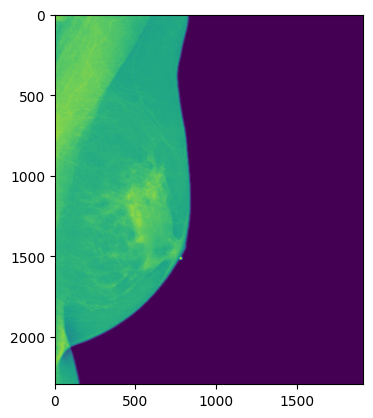

In [107]:
plt.imshow(dataset.pixel_array)

idx:0,file_name:541722628.dcm
idx:1,file_name:270344397.dcm
idx:2,file_name:220375232.dcm
idx:3,file_name:1031443799.dcm


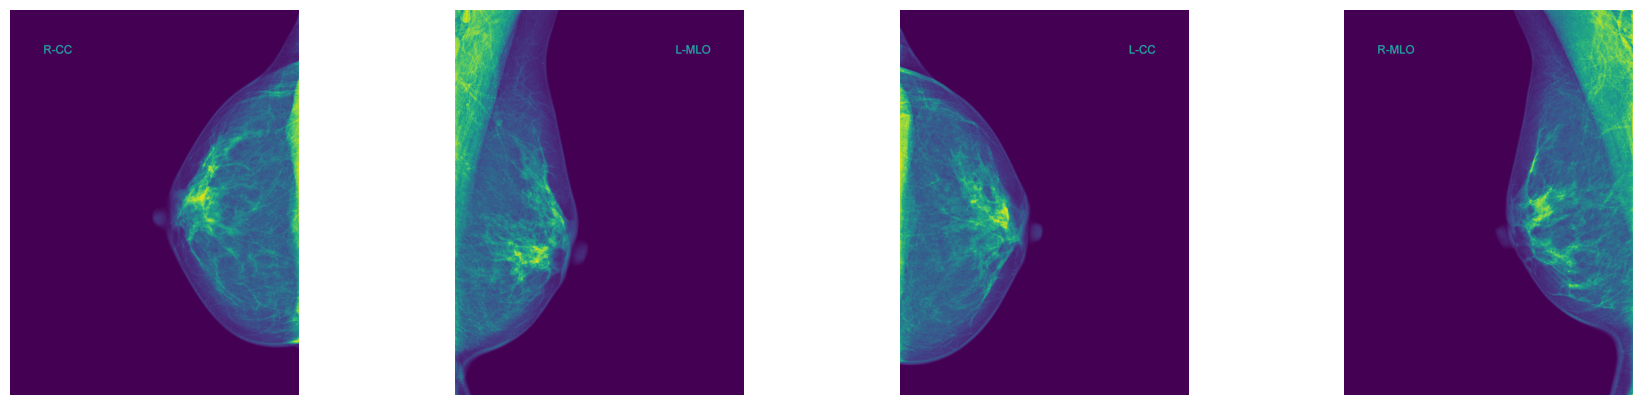

In [82]:
patient_images(10011)    

idx:0,file_name:1864590858.dcm
idx:1,file_name:462822612.dcm
idx:2,file_name:1459541791.dcm
idx:3,file_name:1874946579.dcm


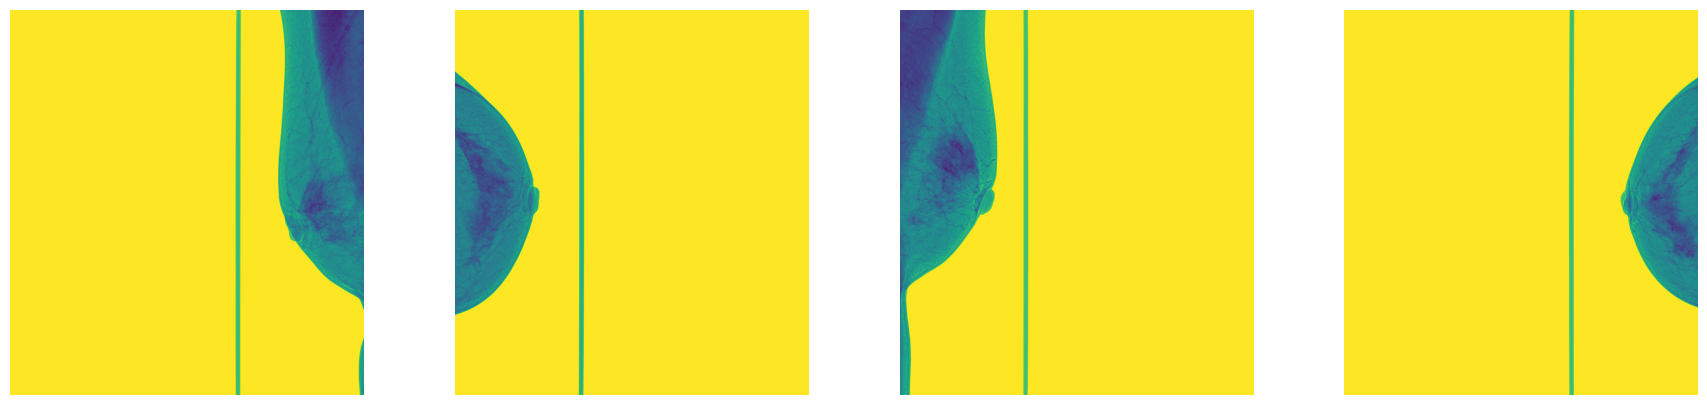

In [49]:
patient_images(train['patient_id'].unique()[0])    

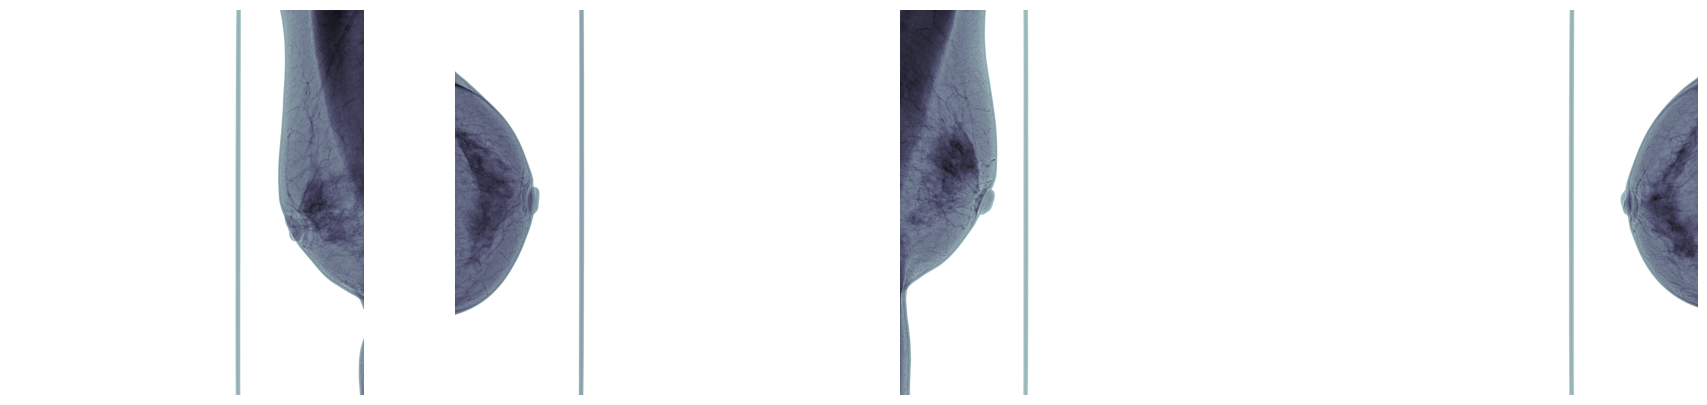

In [41]:
patient_images(train['patient_id'].unique()[0])    

In [40]:
cropping_info_df = pd.DataFrame(columns=['PID','side', 'orientation', 'top','bottom','left','right','view'])

In [150]:
train[train.patient_id ==35218]

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,orientation,path,dump_path
23671,2,35218,78791536,L,MLO,64.0,0,0,0,NaN,0,NaN,29,False,L-MLO,train_images/35218/78791536.dcm,train_images_png/35218/78791536.png
23672,2,35218,410192639,L,CC,64.0,0,0,0,NaN,0,NaN,29,False,L-CC,train_images/35218/410192639.dcm,train_images_png/35218/410192639.png
23673,2,35218,808455422,R,CC,64.0,0,0,0,NaN,0,NaN,29,False,R-CC,train_images/35218/808455422.dcm,train_images_png/35218/808455422.png
23674,2,35218,1310152530,R,MLO,64.0,0,0,0,NaN,0,NaN,29,False,R-MLO,train_images/35218/1310152530.dcm,train_images_png/35218/1310152530.png


In [151]:
dcm_path = "train_images/"
dcm_path = ''.join(dcm_path + '35218' + '/' + '78791536.dcm')
# dcm_path = ''.join(dcm_path + '10006' + '/' + '462822612.dcm')


In [152]:
dcm_path

'train_images/35218/78791536.dcm'

In [153]:
img = pydicom.read_file(dcm_path).pixel_array
img = (img - img.min()) /(img.max() - img.min())
img *= 255
img = np.uint8(img)


data = dcmread(dcm_path)

In [154]:
img.shape

(5355, 4915)

In [156]:
# img = pydicom.read_file(dcm_path).pixel_array
# img = (img - img.min()) /(img.max() - img.min())
# img = 1 - img
# img *= 255
# img = np.uint8(img)




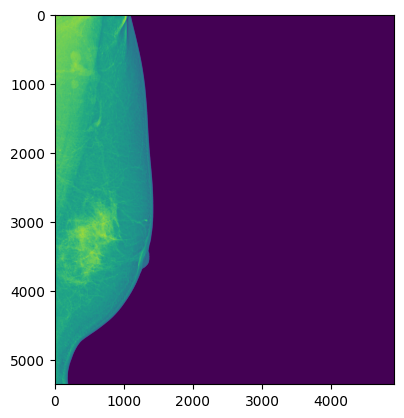

In [158]:
plt.imshow(img)

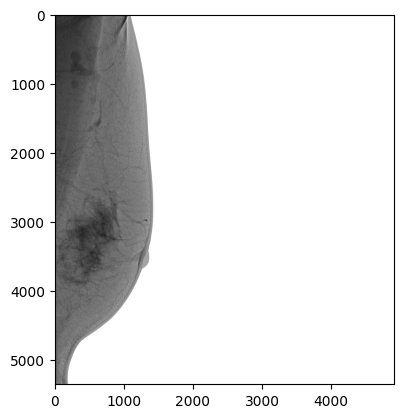

In [155]:
plt.imshow(img,cmap='gray')

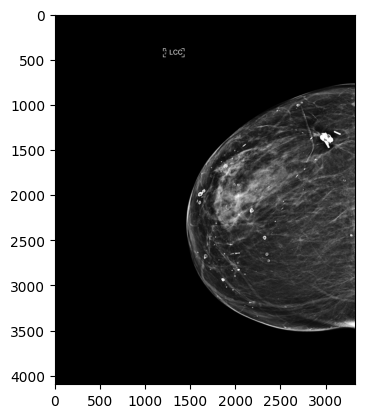

In [520]:
plt.imshow(data.pixel_array,cmap='gray')

In [309]:
data.pixel_array.shape

(2776, 2082)

In [133]:
crop_single_mammogram1('9989', img, 'L-MLO', 'check/test1.png' ,'')
# crop_single_mammogram('10006', img, 'L-CC', 'check/test.png' ,'')

/tmp/ipykernel_176036/580154610.py:144: DeprecationWarning: Please use `binary_erosion` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  img_mask = scipy.ndimage.morphology.binary_erosion(img_mask, iterations=iterations)
/tmp/ipykernel_176036/580154610.py:151: DeprecationWarning: Please use `binary_dilation` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  largest_mask = scipy.ndimage.morphology.binary_dilation(largest_mask, iterations=iterations)
/tmp/ipykernel_176036/965927359.py:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cropping_info_df = cropping_info_df.append({'PID': PID, 'side': side, 'orientation': orientation, \


In [134]:
img.shape

(2776, 2082)

In [539]:
check_data

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,orientation,path,dump_path
87,1,10130,388811999,L,MLO,71.0,1,1,1,0.0,0,B,49,False,L-MLO,train_images/10130/388811999.dcm,check_train_images_png/10130/388811999.png
88,1,10130,613462606,L,CC,71.0,1,1,1,0.0,0,B,49,False,L-CC,train_images/10130/613462606.dcm,check_train_images_png/10130/613462606.png
89,1,10130,1360338805,L,CC,71.0,1,1,1,0.0,0,B,49,False,L-CC,train_images/10130/1360338805.dcm,check_train_images_png/10130/1360338805.png
90,1,10130,1672636630,L,MLO,71.0,1,1,1,0.0,0,B,49,False,L-MLO,train_images/10130/1672636630.dcm,check_train_images_png/10130/1672636630.png
91,1,10130,1013166704,R,CC,71.0,0,0,0,NaN,0,B,49,False,R-CC,train_images/10130/1013166704.dcm,check_train_images_png/10130/1013166704.png
92,1,10130,1165309236,R,CC,71.0,0,0,0,NaN,0,B,49,False,R-CC,train_images/10130/1165309236.dcm,check_train_images_png/10130/1165309236.png
93,1,10130,2110820077,R,MLO,71.0,0,0,0,NaN,0,B,49,False,R-MLO,train_images/10130/2110820077.dcm,check_train_images_png/10130/2110820077.png


In [609]:
dcm_path = "train_images/"
dcm_path = ''.join(dcm_path + '10130' + '/' + '1013166704.dcm')

In [ ]:
for idx, id in enumerate(monochrome1_id):
    
    base_path = "train_images/"
    dcm_list = listdir(dcm_path + str(9989) + '/')
    for file in dcm_list:
        dcm_path = ''.join(base_path + str(id) + '/' + file)
        if idx < 1:
            sys.exit()
        
        

In [610]:
# check_load = cv2.imread('train_images/10130/613462606.png')
# check_load = cv2.imread('check/test.png')
data = dcmread(dcm_path)

In [611]:
check_load.shape

(4096, 3328, 3)

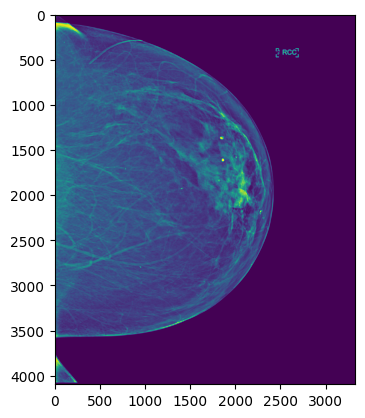

In [612]:
# plt.imshow(check_load[:,:,1])
plt.imshow(data.pixel_array)

In [99]:
cropping_info_df

,PID,side,orientation,top,bottom,left,right,view
0,9967,L,MLO,0,4096,0,3328,1
1,9967,L,CC,0,4096,0,3328,1
2,9967,R,MLO,0,4096,0,3328,1
3,9967,R,CC,0,4096,0,3328,1
4,9968,L,CC,0,4096,0,3328,1
5,9968,L,MLO,0,4096,0,3328,1
6,9968,R,MLO,0,4096,0,3328,1
7,9968,R,CC,0,4096,0,3328,1
8,997,L,CC,0,3328,0,2560,1
9,997,L,MLO,0,3328,0,2560,1


In [38]:
#look for first non zero row and you have an answer

In [306]:
img.shape

(2776, 2082)

In [135]:
check_data = train[train["patient_id"]==10273]

In [136]:
check_data

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,orientation,path,dump_path
4560,2,14954,671188445,L,MLO,57.0,0,0,0,NaN,0,NaN,21,False,L-MLO,train_images/14954/671188445.dcm,train_images_png/14954/671188445.png
4561,2,14954,836443757,L,CC,57.0,0,0,0,NaN,0,NaN,21,False,L-CC,train_images/14954/836443757.dcm,train_images_png/14954/836443757.png
4562,2,14954,495842298,R,CC,57.0,0,0,0,NaN,0,NaN,21,False,R-CC,train_images/14954/495842298.dcm,train_images_png/14954/495842298.png
4563,2,14954,1581972954,R,MLO,57.0,0,0,0,NaN,0,NaN,21,False,R-MLO,train_images/14954/1581972954.dcm,train_images_png/14954/1581972954.png


In [189]:
from joblib import Parallel, delayed
import pathlib

def as_per_laterailty(img,unique_val,laterality_,laterality):
    crop_x = unique_val[unique_val['nunique']>2].iloc[laterality_]['index']
    if laterality == "L" :
        crop_image = img[:,:crop_x+20]
    else:
        crop_image = img[:, crop_x-20:]
    return crop_image

def crop_images(row):
    
    # read_images
    dcm_path,laterality,export_path = row['path'], row['laterality'], row['dump_path']
    data = pydicom.read_file(dcm_path)
    img = data.pixel_array
    img = (img - img.min()) /(img.max() - img.min())
    if data.PhotometricInterpretation == "MONOCHROME1":
        img = 1 - img
    img *= 255
    img = np.uint8(img)
    
    crop_df = pd.DataFrame(img)
    unique_val = crop_df.nunique().reset_index().rename(columns={0:'nunique'})
    laterality_ = -1 if laterality == "L" else 1
    crop_image = as_per_laterailty(img.copy(),unique_val,laterality_,laterality)
    if crop_image.shape[1] < 500:
        if laterality == "L" :
            crop_image = as_per_laterailty(img,unique_val,laterality_=1,laterality="R")
        else:
            crop_image = as_per_laterailty(img,unique_val,laterality_=-1,laterality="L")
    
        
    export_dir = export_path.split(str(row['patient_id']))[0]+str(row['patient_id'])
    pathlib.Path(export_dir).mkdir(parents=True, exist_ok=True)
    plt.imsave(export_path, crop_image, cmap='gray')
    

In [71]:
check_img.shape

(4096, 19, 3)

In [185]:
monochrome1_data = train[train['patient_id'].isin(monochrome1_id)]

In [184]:
monochrome1_id = [int(i) for i in monochrome1_id]

In [193]:
print(monochrome1_id[:10])

[35218, 34341, 59176, 5702, 1380, 38107, 38703, 26962, 33568, 59944]


In [188]:
monochrome1_data['patient_id'].nunique() , len(monochrome1_id)

(2255, 2255)

In [176]:
train.head()

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,orientation,path,dump_path
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False,L-CC,train_images/10006/462822612.dcm,train_images_png/10006/462822612.png
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False,L-MLO,train_images/10006/1459541791.dcm,train_images_png/10006/1459541791.png
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False,R-MLO,train_images/10006/1864590858.dcm,train_images_png/10006/1864590858.png
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False,R-CC,train_images/10006/1874946579.dcm,train_images_png/10006/1874946579.png
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True,L-CC,train_images/10011/220375232.dcm,train_images_png/10011/220375232.png


In [175]:
monochrome1_data['patient_id']

Series([], Name: patient_id, dtype: int64)

In [190]:
# Create a Parallel object with 4 worker processes
with Parallel(n_jobs=64) as parallel:
    # Create a list of delayed objects for each row of the DataFrame
    data = [delayed(crop_images)(row) for _, row in monochrome1_data.iterrows()]

    # Apply the function concurrently to the list of delayed objects
    parallel(data)



In [274]:
check_load[:,:,1].shape

(2776, 2082)

In [180]:
dcm_path = "input_data/train_images/"
dcm_path = ''.join(dcm_path + '8421' + '/' + '1138041525.dcm')

In [177]:
dcm_path = 'input_data/train_images_png/8421/1138041525.png'

In [91]:
load_img = cv2.imread(dcm_path)
nres = (1024,512)

In [92]:
resized_img = cv2.resize(load_img, (nres[1], nres[0]), interpolation = cv2.INTER_NEAREST)

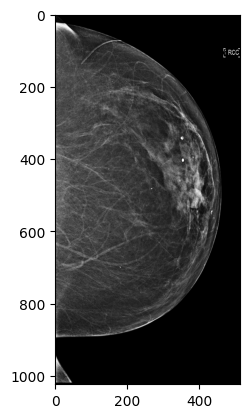

In [93]:
plt.imshow(resized_img)

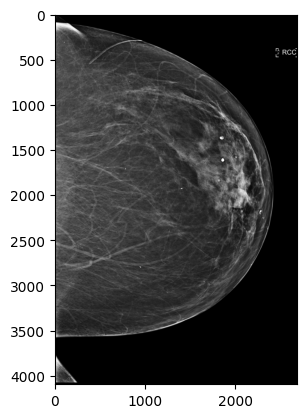

In [87]:
plt.imshow(load_img)

In [181]:
data  = pydicom.read_file(dcm_path)

In [182]:
data.PhotometricInterpretation

'MONOCHROME2'

In [183]:
# cc = check_load[:,:,1]
img = pydicom.read_file(dcm_path).pixel_array
img = img - img.min()
img = img /(img.max() - img.min())
img *= 255
img = np.uint8(img)

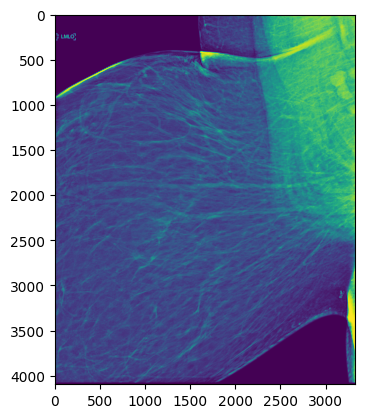

In [184]:
plt.imshow(img)

In [141]:
cc1 = pd.DataFrame(img)

In [142]:
val = cc1.nunique().reset_index().rename(columns={0:'nunique'})

In [143]:
val

,index,nunique
0,0,68
1,1,69
2,2,70
3,3,70
4,4,72
...,...,...
2077,2077,1
2078,2078,1
2079,2079,1
2080,2080,1


In [144]:
val[val['nunique']>2]

,index,nunique
0,0,68
1,1,69
2,2,70
3,3,70
4,4,72
...,...,...
1868,1868,39
1869,1869,31
1870,1870,18
1871,1871,7


In [145]:
val[val['nunique']>2].iloc[-1]['index']


1872

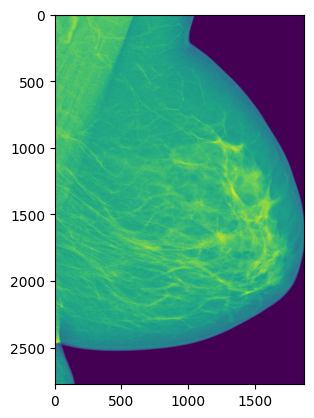

In [147]:
# plt.imshow(img[:, 1600:1782])
plt.imshow(img[:, :1872])

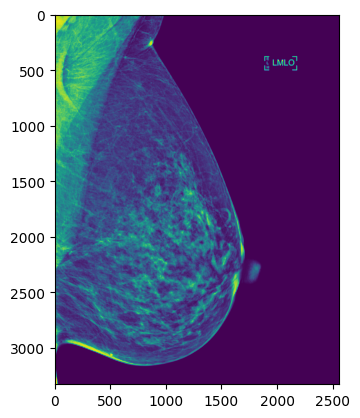

In [106]:
plt.imshow(img)

In [62]:
plt.imsave("check1.png", img[:, 1087:], cmap='gray')

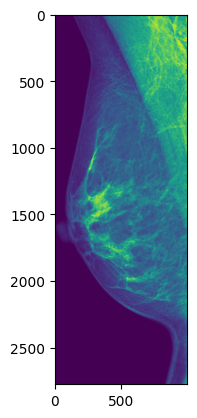

In [41]:
plt.imshow(data[:, 1087:])

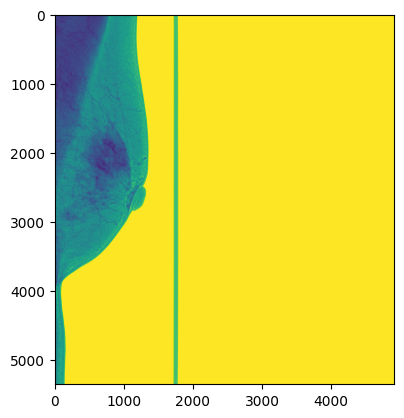

In [405]:
plt.imshow(img)

In [194]:

# Find the unique values in the column
unique = np.unique(cc,axis=0)

In [195]:
unique.shape

(3355, 1221)

In [196]:
unique

array([[ 13,  12,  19, ..., 255, 255, 255],
       [ 19,  29,  30, ..., 255, 255, 255],
       [ 20,  20,  20, ..., 255, 255, 255],
       ...,
       [154, 163, 176, ..., 255, 255, 255],
       [174, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

In [159]:
np.unique(a[:,0])

array([1, 2])

In [215]:
a = np.array([[1, 0, 0], [1, 1, 0], [2, 3, 4],[5, 0, 0]])

In [216]:
a

array([[1, 0, 0],
       [1, 1, 0],
       [2, 3, 4],
       [5, 0, 0]])

In [221]:
pd.DataFrame(a)

,0,1,2
0,1,0,0
1,1,1,0
2,2,3,4
3,5,0,0


In [220]:
for i in range(a.shape[-1]):
    print(a[:,i],"LLLL",np.unique(a[:,i]))

[1 1 2 5] LLLL [1 2 5]
[0 1 3 0] LLLL [0 1 3]
[0 0 4 0] LLLL [0 4]


In [150]:
total_unique = np.sum(unique, axis=0)

In [151]:
total_unique

array([4, 4, 4])

In [111]:

# Find the unique values in each column of the array


# Load the CSV Information 

In [10]:
from sklearn.model_selection import StratifiedGroupKFold

In [8]:
train  = pd.read_csv('input_data/train.csv')
test  = pd.read_csv('input_data/test.csv')

In [9]:
train['orientation'] = train['laterality'].map(str)+"-"+train['view'].map(str)

In [234]:
# train[train['cancer']==1]

In [235]:
# canc = train.groupby(['patient_id']).agg({'cancer':'nunique'}).reset_index()

In [236]:
# check_data = train[train['patient_id']==10130]

In [237]:
train.head()

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,orientation
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False,L-CC
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False,L-MLO
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False,R-MLO
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False,R-CC
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True,L-CC


In [238]:
test.head()

,site_id,patient_id,image_id,laterality,view,age,implant,machine_id,prediction_id
0,2,10008,736471439,L,MLO,81,0,21,10008_L
1,2,10008,1591370361,L,CC,81,0,21,10008_L
2,2,10008,68070693,R,MLO,81,0,21,10008_R
3,2,10008,361203119,R,CC,81,0,21,10008_R


In [239]:
# train.apply(lambda row : print(row.patient_id))

In [240]:
train['orignal_path'] = train.apply(lambda row : ''.join('input_data/train_images/'+str(row['patient_id'])+'/'+str(row['image_id'])+'.dcm'), axis=1)

In [241]:
train['dump_path'] = train.apply(lambda row : ''.join('input_data/train_images_png/'+str(row['patient_id'])+'/'+str(row['image_id'])+'.png'), axis=1)

In [15]:
# train[train["patient_id"]==10011]

In [242]:
train.shape , test.shape

((54706, 17), (4, 9))

In [8]:
train[train.cancer==1].shape

(53548, 14)

In [9]:
train.isnull().sum()

site_id                        0
patient_id                     0
image_id                       0
laterality                     0
view                           0
age                           37
cancer                         0
biopsy                         0
invasive                       0
BIRADS                     28420
implant                        0
density                    25236
machine_id                     0
difficult_negative_case        0
dtype: int64

In [101]:
import model
import engine

In [6]:
all_gpu_id = [ i for i in range(8)]

In [111]:
3 in all_gpu_id 

True

In [113]:
all_gpu_id.remove(3)

In [116]:
[3] + all_gpu_id

[3, 0, 1, 2, 4, 5, 6, 7]

In [99]:
model_ = model.RSNAModel(output_size = 1,n_cols=6,pos_weight=2)
features = efficientnet_b4(pretrained=True)

In [102]:
engine.split_model_parallel(model_)

[Sequential(
   (0): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
   (1): BatchNormAct2d(
     48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
     (drop): Identity()
     (act): SiLU(inplace=True)
   )
   (2): Sequential(
     (0): Sequential(
       (0): DepthwiseSeparableConv(
         (conv_dw): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
         (bn1): BatchNormAct2d(
           48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
           (drop): Identity()
           (act): SiLU(inplace=True)
         )
         (se): SqueezeExcite(
           (conv_reduce): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
           (act1): SiLU(inplace=True)
           (conv_expand): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
           (gate): Sigmoid()
         )
         (conv_pw): Conv2d(48, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
         (bn2): BatchNormAct2

In [100]:
len(list(model_.features.children())[:5])

5

In [97]:
len(list(features.children()))

7

In [25]:
train.BIRADS.value_counts()

1.0    15772
0.0     8249
2.0     2265
Name: BIRADS, dtype: int64

In [20]:
train[(train.implant ==1) & (train.cancer==1)]

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
2585,1,12725,156027166,R,MLO,60.0,1,1,1,0.0,1,C,49,False
2586,1,12725,1289574047,R,CC,60.0,1,1,1,0.0,1,C,49,False
2587,1,12725,1297379916,R,CC,60.0,1,1,1,0.0,1,C,49,False
2588,1,12725,1435663649,R,CC,60.0,1,1,1,0.0,1,C,49,False
7581,1,18026,927775324,R,CC,67.0,1,1,1,0.0,1,B,49,False
7582,1,18026,1303889904,R,CC,67.0,1,1,1,0.0,1,B,49,False
7583,1,18026,1905432390,R,MLO,67.0,1,1,1,0.0,1,B,49,False
7584,1,18026,1943507092,R,MLO,67.0,1,1,1,0.0,1,B,49,False
7585,1,18026,2091972299,R,CC,67.0,1,1,1,0.0,1,B,49,False
48792,1,62608,344315857,L,MLO,72.0,1,1,1,0.0,1,B,49,False


In [22]:
train[(train.implant !=1) & (train.cancer==1)]

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
87,1,10130,388811999,L,MLO,71.0,1,1,1,0.0,0,B,49,False
88,1,10130,613462606,L,CC,71.0,1,1,1,0.0,0,B,49,False
89,1,10130,1360338805,L,CC,71.0,1,1,1,0.0,0,B,49,False
90,1,10130,1672636630,L,MLO,71.0,1,1,1,0.0,0,B,49,False
190,1,10226,461614796,L,MLO,71.0,1,1,1,0.0,0,C,49,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54485,2,9707,1900919592,R,MLO,56.0,1,1,1,NaN,0,NaN,21,False
54593,2,9840,111786935,R,MLO,59.0,1,1,1,NaN,0,NaN,21,False
54594,2,9840,1559360810,R,CC,59.0,1,1,1,NaN,0,NaN,21,False
54595,2,9851,1409270544,L,MLO,58.0,1,1,0,NaN,0,NaN,48,False


In [164]:
train[train.machine_id ==49]['age'].mean().astype(int)

57

In [165]:
train.loc[train.age.isnull(),['age']] = train[train.machine_id ==49]['age'].mean().astype(int)

In [244]:
def create_folds(data, num_splits):
    data["kfold"] = -1
    sgkf = StratifiedGroupKFold(num_splits)
    for f, (t_, v_) in enumerate(sgkf.split(data, data.cancer, groups=data.patient_id)):
        data.loc[v_, "kfold"] = f

    return data

In [245]:
train_folds = create_folds(train, 5)

In [246]:
train_folds.head()

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,orientation,orignal_path,dump_path,kfold
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False,L-CC,input_data/train_images/10006/462822612.dcm,input_data/train_images_png/10006/462822612.png,3
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False,L-MLO,input_data/train_images/10006/1459541791.dcm,input_data/train_images_png/10006/1459541791.png,3
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False,R-MLO,input_data/train_images/10006/1864590858.dcm,input_data/train_images_png/10006/1864590858.png,3
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False,R-CC,input_data/train_images/10006/1874946579.dcm,input_data/train_images_png/10006/1874946579.png,3
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True,L-CC,input_data/train_images/10011/220375232.dcm,input_data/train_images_png/10011/220375232.png,1


In [159]:
train_folds.to_csv('input_data/kfold_train.csv', index=False)

In [248]:
train_folds.groupby(['patient_id'])['kfold'].count().reset_index()

,patient_id,kfold
0,5,4
1,25,6
2,28,4
3,30,4
4,33,5
...,...,...
11908,65518,4
11909,65525,4
11910,65526,4
11911,65530,6


# Check data loader 


In [4]:
import torch
import torchvision

In [5]:
train_folds = pd.read_csv('input_data/kfold_train.csv')

In [6]:
laoder_check = train_folds[train_folds['patient_id'].isin([10130,115,90,25])] #,115,90,10130,

In [6]:
def get_transforms(aug=False):
    
    def transforms(img):
        img = img.convert('RGB')
        if aug:
            tfm = [
                torchvision.transforms.RandomHorizontalFlip(0.5),
                torchvision.transforms.RandomRotation(degrees=(-5, 5)), 
                torchvision.transforms.RandomResizedCrop((1024, 512), scale=(0.8, 1), ratio=(0.45, 0.55)) 
            ]
        else:
            tfm = [
                torchvision.transforms.Resize((1024, 1024))
            ]
        img = torchvision.transforms.Compose(tfm + [            
            torchvision.transforms.ToTensor(),
            # torchvision.transforms.Normalize(mean=0.2179, std=0.0529),
            ])(img)
        
        return img
    
    return lambda img: transforms(img)


In [15]:
train_folds.shape

(54706, 19)

In [7]:
train_folds.head()

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,orientation,orignal_path,dump_path,kfold,mean_age
0,2,10006,462822612,0,1,61.0,0,0,0,NaN,0,NaN,29,False,L-CC,input_data/train_images/10006/462822612.dcm,input_data/train_images_png/10006/462822612.png,3,59.153744
1,2,10006,1459541791,0,0,61.0,0,0,0,NaN,0,NaN,29,False,L-MLO,input_data/train_images/10006/1459541791.dcm,input_data/train_images_png/10006/1459541791.png,3,59.153744
2,2,10006,1864590858,1,0,61.0,0,0,0,NaN,0,NaN,29,False,R-MLO,input_data/train_images/10006/1864590858.dcm,input_data/train_images_png/10006/1864590858.png,3,59.153744
3,2,10006,1874946579,1,1,61.0,0,0,0,NaN,0,NaN,29,False,R-CC,input_data/train_images/10006/1874946579.dcm,input_data/train_images_png/10006/1874946579.png,3,59.153744
4,2,10011,220375232,0,1,55.0,0,0,0,0.0,0,NaN,21,True,L-CC,input_data/train_images/10011/220375232.dcm,input_data/train_images_png/10011/220375232.png,1,60.198516


In [10]:
train_folds['laterality'] = train_folds['laterality'].map({'L' :0 , "R":1})
train_folds['view'] = train_folds['view'].map({'MLO':0 , "CC":1, "AT":2, "LM": 3, "ML": 4, "LMO": 5})

In [11]:
train_folds['mean_age'] = train_folds.groupby(['site_id','machine_id'])['age'].transform('mean')

In [12]:
train_folds.loc[train_folds.age.isnull(),['age']] = train_folds['mean_age']

In [24]:
CATEGORY_AUX_TARGETS = ['site_id', 'laterality', 'view', 'implant', 'machine_id', 'age']
TARGET = 'cancer'


In [9]:
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch 

In [10]:
class RSNADataSet(torch.utils.data.Dataset):
    def __init__(self, df, image_path, transforms=None, test=False):
        super().__init__()
        self.df = df
        self.path = image_path
        self.transforms = transforms
        self.test = test

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, item):
        
        image = cv2.imread(self.df.iloc[item][self.path])
        
        if self.transforms is not None:
            image = self.transforms(image=image)['image']

        if self.test:
            return {
                "image": image
                    }
        else:
            return {
                "image":image,
                "image_id": torch.as_tensor(self.df.iloc[item]['image_id']),
                "target":torch.as_tensor(self.df.iloc[item][TARGET]),
                "meta":torch.as_tensor(self.df.iloc[item][CATEGORY_AUX_TARGETS])
                    }
        
train_transform = A.Compose([
        A.Resize(2048,1024),
        # A.LongestMaxSize(max_size=args.img_size, interpolation=1, p=1.0),
        # A.CenterCrop(height=1024, width=1024, p=1.0),
        # A.CoarseDropout(always_apply=False, p=0.5, min_holes=8, max_holes=16, min_height=16, min_width=16, max_height=16, max_width=16),
        # A.ElasticTransform(always_apply=False, p=0.3, alpha=1.0, sigma=50.0, alpha_affine=50.0, interpolation=0, border_mode=0, value=(0, 0, 0), mask_value=None, approximate=False),
        # A.Normalize(mean=IMAGENET_DEFAULT_MEAN, std=IMAGENET_DEFAULT_STD),
        ToTensorV2()
    ]) 

def proprocess_collate(batch):
        d = {}
        key = batch[0].keys()
        for k in key:
            d[k] = [b[k] for b in batch] 
        d['image'] = torch.stack(d['image'], 0).unsqueeze(1)
        return d

In [16]:
class RSNADataloader:
    def __init__(self, df,image_path, transforms=None, test=False):
        self.df = df
        self.path = image_path
        self.transforms = transforms
        self.test = test
        self.dataset = RSNADataSet(
            df=self.df, image_path=self.path,transforms=self.transforms, test=self.test)

    def fetch(self, batch_size, num_workers,drop_last=False, shuffle=True):
        sampler = None  # torch.utils.data.RandomSampler(self.dataset)
        data_loader = torch.utils.data.DataLoader(
            self.dataset, batch_size=batch_size, sampler=sampler, shuffle=shuffle, num_workers=num_workers, drop_last=drop_last)
        return data_loader

In [45]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.distributed import DistributedSampler




    
# class PositiveSampleDataLoader(DataLoader):
#     def __init__(self, dataset, batch_size, shuffle=True, num_workers=0, positive_class=None):
#         self.dataset = dataset
#         self.batch_size = batch_size
#         self.shuffle = shuffle
#         self.num_workers = num_workers
#         self.positive_class = positive_class
        
#     def __iter__(self):
#         positive_indices = [i for i in range(len(self.dataset)) if self.dataset.labels[i] == self.positive_class]
#         if self.shuffle:
#             np.random.shuffle(positive_indices)
            
#         if len(positive_indices) < self.batch_size:
#             raise ValueError("Not enough positive samples in the dataset.")
            
#         for i in range(0, len(positive_indices), self.batch_size):
#             batch_indices = positive_indices[i:i + self.batch_size]
#             yield [self.dataset[i] for i in batch_indices]

            
            
         
            
# # Initialize the dataset
# positive_class = 1
# dataset = PositiveSampleDataset(data, labels, positive_class)

# # Initialize the DistributedSampler
# dist_sampler = DistributedSampler(dataset)

# # Create the PositiveSampleDataLoader
# dataloader = PositiveSampleDataLoader(dataset, batch_size=64, positive_class=positive_class, sampler=dist_sampler)



class PositiveSampleDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

class PositiveSampleDataLoader(DataLoader):
    def __init__(self, dataset, batch_size, shuffle=True, num_workers=0):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.num_workers = num_workers
        self.init_iter()

    def init_iter(self):
        self.positive_indices = torch.where(self.dataset['target'] == 1)[0]
        self.negative_indices = torch.where(self.dataset['target'] == 0)[0]
        if self.shuffle:
            torch.randperm(self.positive_indices)
            torch.randperm(self.negative_indices)
        self.positive_iter = iter(self.positive_indices)
        self.negative_iter = iter(self.negative_indices)

    def __iter__(self):
        self.init_iter()
        return self

    def __next__(self):
        positive_batch = []
        negative_batch = []
        for _ in range(self.batch_size):
            try:
                positive_batch.append(next(self.positive_iter))
            except StopIteration:
                self.positive_iter = iter(self.positive_indices)
                positive_batch.append(next(self.positive_iter))
            try:
                negative_batch.append(next(self.negative_iter))
            except StopIteration:
                self.negative_iter = iter(self.negative_indices)
                negative_batch.append(next(self.negative_iter))
        positive_batch.extend(negative_batch)
        return self.dataset[positive_batch]



In [1243]:

class BalancedBatchSampler(torch.utils.data.sampler.BatchSampler):
    def __init__(self, dataset, n_positive_per_batch, batch_size):
        self.dataset = dataset
        self.batch_size = batch_size 
        self.positive_class = self.dataset.positive_class
        self.positive_indices = [i for i, x in enumerate(self.dataset.df['cancer']) if x == self.positive_class]
        self.negative_indices = [i for i, x in enumerate(self.dataset.df['cancer']) if x != self.positive_class]
        self.indices = self.positive_indices + self.negative_indices #len(self.dataset.df)
        self.sample_list = []
        self.n_positive_per_batch = n_positive_per_batch
        self.sufficient_postives = True if len(self.positive_indices) < self.n_positive_per_batch*(len(self.dataset.df) // self.batch_size+1) else False
        if self.sufficient_postives:
            
            self.upsample_positive_indices = random.choices(self.positive_indices, k=self.n_positive_per_batch*(len(self.dataset.df) // self.batch_size))
            print("HAVE TO UPSAMPLE>>>>>",self.n_positive_per_batch*(len(self.dataset.df) // self.batch_size),"<<<<<")
        else:
            self.upsample_positive_indices = self.positive_indices
            
            
    
    def __iter__(self):
        # if self.positive_indices < 
        # self.positive_indices.extend(random.sample(self.positive_indices, self.upsample_factor+1))
        # while len(self.positive_indices) < len(self.negative_indices):
        #     self.positive_indices += self.positive_indices
        print("!!!!!!!!!!")
        print(self.positive_indices ,"postive indice",type(self.positive_indices))
        print(self.upsample_positive_indices,"upsample_positive_indices")
        print(self.negative_indices ,"negative indice")
        # indices = self.positive_indices + self.negative_indices
        # print("indices=>>", indices)
        print("BS",self.batch_size,len(self.indices))
        print("#############")

        
        for i in range(0,len(self.indices),self.batch_size):
            print(i,"OOO")
            #TODO sample (n from negative ,1 or 2 fron postive whne positvce is exhausetd then sample from upsample_positive_indices
            print("LENGTH OF NEGATIVE INDICES+>>",len(self.negative_indices))
            batch = min(self.batch_size,len(self.indices)-i)
            if batch < self.batch_size:
                n_postive = batch
                self.sample_list = random.sample(self.negative_indices,len(self.negative_indices))
                self.negative_indices = [i for i in self.negative_indices if i not in self.sample_list]
                print("n_postive|||||",n_postive)
            else:
                n_postive = random.randint(1, self.n_positive_per_batch)
                print("n_postive|||||",n_postive)
                self.sample_list = random.sample(self.negative_indices,min(batch-n_postive, len(self.negative_indices)))
                self.negative_indices = [i for i in self.negative_indices if i not in self.sample_list]
                
            
            print("LENGTH OF POSTIVE INDICES+>>",len(self.upsample_positive_indices))
            # if len(self.positive_indices) > 0:
            #     self.sample_list.extend(random.sample(self.positive_indices,min(n_postive, len(self.positive_indices))))
            #     # self.sample_list.append(random.choice(self.positive_indices))
            #     self.positive_indices = [i for i in self.positive_indices if i not in self.sample_list]
            # else:
            indices_to_remove = random.sample(self.upsample_positive_indices,min(n_postive, len(self.upsample_positive_indices))) 
            print("indices to remove",indices_to_remove)
            self.sample_list.extend(indices_to_remove)
            # self.upsample_positive_indices = [i for i in self.upsample_positive_indices if i not in self.sample_list]
            self.upsample_positive_indices = [x for i, x in enumerate(self.upsample_positive_indices) if i not in indices_to_remove]
            random.shuffle(self.sample_list)
            print(self.sample_list,">>>>>>SAMPLE LIST>>")
            yield self.sample_list
        

        
#     def __iter__(self):
#         # if self.positive_indices < 
#         # self.positive_indices.extend(random.sample(self.positive_indices, self.upsample_factor+1))
#         # while len(self.positive_indices) < len(self.negative_indices):
#         #     self.positive_indices += self.positive_indices
        
#         print(self.positive_indices ,"postive indice",type(self.positive_indices))
#         print(self.negative_indices ,"negative indice")
#         # indices = self.positive_indices + self.negative_indices
#         # print("indices=>>", indices)
#         print("#############")
        
        
#         # random.shuffle(indices)
#         for i in range(0, len(self.indices), self.batch_size):
#         # for i in range(0, len(indices), self.batch_size):
#             batch = self.indices[i:i + self.batch_size]
#             # newbatch = self.negative_indices[i:i+self.batch_size-1]
#             # newbatch.extend([self.positive_indices.pop()])
#             n_list = random.sample(self.negative_indices, self.batch_size-1)
#             n_list.extend(random.sample(self.positive_indices,1))
#             print(i,">>>",batch,">>>>",n_list)
#             # self.negative_indices = [x for x in n_list if x not in self.negative_indices]
#             # print(self.negative_indices,"PPPPPP")
#             # pos = 0
#             # print(batch,">>>>>")
#             # for idx in batch:
#             #     if self.dataset.df.iloc[idx]['cancer'] == self.positive_class:
#             #         pos += 1
#             #     if pos > 2:
#             #         continue
#             yield batch
    
    def __len__(self):
        return len(self.dataset) // self.batch_size


In [1229]:
class BalancedBatchSampler(torch.utils.data.sampler.BatchSampler):
    def __init__(self, dataset, n_positive_per_batch, batch_size):
        self.dataset = dataset
        self.batch_size = batch_size 
        self.positive_class = self.dataset.positive_class
        self.num_samples = len(self.dataset.df)
        self.positive_indices = np.array([i for i, x in enumerate(self.dataset.df['cancer']) if x == self.positive_class])
        self.negative_indices = np.array([i for i, x in enumerate(self.dataset.df['cancer']) if x != self.positive_class])
        # self.indices = self.positive_indices.tolist() + self.negative_indices.tolist() 
        self.sample_list = deque()
        self.n_positive_per_batch = n_positive_per_batch
        self.sufficient_postives = True if len(self.positive_indices) < self.n_positive_per_batch*(self.num_samples // self.batch_size+1) else False
        if self.sufficient_postives:
            self.upsample_positive_indices = np.random.choice(self.positive_indices, size=self.n_positive_per_batch*(self.num_samples // self.batch_size), replace=True)
        else:
            self.upsample_positive_indices = self.positive_indices
        # np.random.shuffle(self.indices)
        
    def __iter__(self):
        for i in range(0, self.num_samples, self.batch_size):
            batch = min(self.batch_size, self.num_samples - i)
            if batch < self.batch_size:
                n_postive = batch
                self.sample_list = np.random.choice(self.negative_indices, size=len(self.negative_indices), replace=False)
                self.negative_indices = np.array([i for i in self.negative_indices if i not in self.sample_list])

            else:
                n_postive = np.random.randint(1, self.n_positive_per_batch+1)
                self.sample_list = np.random.choice(self.negative_indices, size=min(batch-n_postive, len(self.negative_indices)), replace=False)
                self.negative_indices = np.array([i for i in self.negative_indices if i not in self.sample_list])

            indices_to_remove = np.random.choice(self.upsample_positive_indices, size=min(n_postive, len(self.upsample_positive_indices)), replace=False)
            self.sample_list = np.concatenate([self.sample_list,indices_to_remove])
            self.upsample_positive_indices = np.array([x for x in self.upsample_positive_indices if x not in indices_to_remove])
            # print(type(self.sample_list),"LLLLL")
            yield self.sample_list.tolist()

    def __len__(self):
        return len(self.dataset) // self.batch_size+1


In [1244]:
import torch
from collections import deque
from torch.utils.data import DataLoader, Dataset
import random
    
class RSNADataSet(torch.utils.data.Dataset):
    def __init__(self, df, image_path, transforms=None, test=False):
        super().__init__()
        self.df = df
        self.path = str(image_path)
        self.transforms = transforms
        self.test = test
        self.positive_class = 1

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, item):
        
        # print("+++++++++++++++++++")
        # print("KLKLKLKK",item)
        # print("+++++++++++++++++++")
        image = 54#cv2.imread(self.df.iloc[item][self.path])
        
        if self.transforms is not None:
            image = self.transforms(image=image)['image']

        if self.test:
            return {
                "image": image
                    }
        else:
            return {
                "image":image,
                "image_id": str(self.df.iloc[item]['image_id']),
                "target":torch.as_tensor(self.df.iloc[item][TARGET]),
                "meta":torch.as_tensor(self.df.iloc[item][CATEGORY_AUX_TARGETS])
                    }
        
train_transform = A.Compose([
        A.Resize(2048,1024),
        # A.LongestMaxSize(max_size=args.img_size, interpolation=1, p=1.0),
        # A.CenterCrop(height=1024, width=1024, p=1.0),
        # A.CoarseDropout(always_apply=False, p=0.5, min_holes=8, max_holes=16, min_height=16, min_width=16, max_height=16, max_width=16),
        # A.ElasticTransform(always_apply=False, p=0.3, alpha=1.0, sigma=50.0, alpha_affine=50.0, interpolation=0, border_mode=0, value=(0, 0, 0), mask_value=None, approximate=False),
        # A.Normalize(mean=IMAGENET_DEFAULT_MEAN, std=IMAGENET_DEFAULT_STD),
        ToTensorV2()
    ]) 

# class BalancedBatchSampler(torch.utils.data.sampler.BatchSampler):
#     def __init__(self, dataset, n_positive_per_batch, batch_size):
#         self.dataset = dataset
#         self.batch_size = batch_size 
#         self.positive_class = self.dataset.positive_class
#         self.positive_indices = [i for i, x in enumerate(self.dataset.df['cancer']) if x == self.positive_class]
#         self.negative_indices = [i for i, x in enumerate(self.dataset.df['cancer']) if x != self.positive_class]
#         self.indices = self.positive_indices + self.negative_indices 
#         self.sample_list = []
#         self.n_positive_per_batch = n_positive_per_batch
#         self.sufficient_postives = True if len(self.positive_indices) < self.n_positive_per_batch*(len(self.dataset.df) // self.batch_size+1) else False
#         if self.sufficient_postives:
#             self.upsample_positive_indices = random.choices(self.positive_indices, k=self.n_positive_per_batch*(len(self.dataset.df) // self.batch_size))
#         else:
#             self.upsample_positive_indices = random.choices(self.positive_indices, k=len(self.positive_indices))
            
            
    
#     def __iter__(self):
#         for i in range(0,len(self.indices),self.batch_size):
            
#             batch = min(self.batch_size,len(self.indices)-i)
#             if batch < self.batch_size:
#                 n_postive = batch
#                 self.sample_list = random.sample(self.negative_indices,len(self.negative_indices))
#                 self.negative_indices = [i for i in self.negative_indices if i not in self.sample_list]
            
#             else:
#                 n_postive = random.randint(1, self.n_positive_per_batch)
#                 self.sample_list = random.sample(self.negative_indices,min(batch-n_postive, len(self.negative_indices)))
#                 self.negative_indices = [i for i in self.negative_indices if i not in self.sample_list]
                
#             indices_to_remove = random.sample(self.upsample_positive_indices,min(n_postive, len(self.upsample_positive_indices)))
#             self.sample_list.extend(indices_to_remove)
#             self.upsample_positive_indices = [x for i, x in enumerate(self.upsample_positive_indices) if i not in indices_to_remove]
#             yield self.sample_list
        
#     def __len__(self):
#         return len(self.dataset) // self.batch_size+1
    
class RSNADataloader:
    def __init__(self, df,image_path, n_positive_per_batch, batch_size, transforms=None, test=False):
        self.df = df
        self.path = image_path
        self.transforms = transforms
        self.test = test
        self.n_positive_per_batch = n_positive_per_batch
        self.batch_size = batch_size
        self.dataset = RSNADataSet(
            df=self.df, image_path=self.path, transforms=self.transforms, test=self.test)
        self.sampler = BalancedBatchSampler(self.dataset, self.n_positive_per_batch, self.batch_size)

    def fetch(self, num_workers, collate_fn=None, drop_last=False):
        # sampler = None  # torch.utils.data.RandomSampler(self.dataset)
        data_loader = torch.utils.data.DataLoader(
            self.dataset, sampler=self.sampler,num_workers=num_workers, batch_size =8,collate_fn=collate_fn, drop_last=drop_last)
        return data_loader
    
    
rsna_dataset =  RSNADataSet(laoder_check.reset_index(drop=True).loc[:], 'dump_path', transforms=train_transform, test=False)    
# rsna_dataset =  RSNADataSet(train_folds[train_folds.kfold==2].head(1000).reset_index(drop=True), 'dump_path')    

# labels = torch.tensor([rsna_dataset[i]['target'] for i in range(len(rsna_dataset))])

batch_sampler = BalancedBatchSampler(rsna_dataset, 1, 8)



dataloader = DataLoader(rsna_dataset,batch_size=1,batch_sampler=batch_sampler,drop_last=False)

In [1180]:
train_folds.head()

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,orientation,orignal_path,dump_path,kfold,mean_age
0,2,10006,462822612,0,1,61.0,0,0,0,NaN,0,NaN,29,False,L-CC,input_data/train_images/10006/462822612.dcm,input_data/train_images_png/10006/462822612.png,3,59.153744
1,2,10006,1459541791,0,0,61.0,0,0,0,NaN,0,NaN,29,False,L-MLO,input_data/train_images/10006/1459541791.dcm,input_data/train_images_png/10006/1459541791.png,3,59.153744
2,2,10006,1864590858,1,0,61.0,0,0,0,NaN,0,NaN,29,False,R-MLO,input_data/train_images/10006/1864590858.dcm,input_data/train_images_png/10006/1864590858.png,3,59.153744
3,2,10006,1874946579,1,1,61.0,0,0,0,NaN,0,NaN,29,False,R-CC,input_data/train_images/10006/1874946579.dcm,input_data/train_images_png/10006/1874946579.png,3,59.153744
4,2,10011,220375232,0,1,55.0,0,0,0,0.0,0,NaN,21,True,L-CC,input_data/train_images/10011/220375232.dcm,input_data/train_images_png/10011/220375232.png,1,60.198516


In [1142]:
def null_collate(batch):
    d = {}
    key = batch[0].keys()
    print(keys,"*****")
    for k in key:
        d[k] = [b[k] for b in batch]

    d['image'] = torch.stack(d['image']).unsqueeze(1)
    return d


In [1245]:
ds_train = RSNADataloader(laoder_check.reset_index(drop=True), 'dump_path', n_positive_per_batch=1, batch_size =8, transforms=train_transform, test=False).fetch(
        num_workers=0 , drop_last=False)

In [1241]:
laoder_check.shape

(21, 19)

In [1236]:
# vb = next(iter(ds_train)) 

In [1246]:
for data in ds_train:
    print(data['target'])

!!!!!!!!!!
[0, 1, 2, 3] postive indice <class 'list'>
[0, 1, 2, 3] upsample_positive_indices
[4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20] negative indice
BS 8 21
#############
0 OOO
LENGTH OF NEGATIVE INDICES+>> 17
n_postive||||| 1
LENGTH OF POSTIVE INDICES+>> 4
indices to remove [3]
[12, 11, 13, 15, 5, 3, 16, 7] >>>>>>SAMPLE LIST>>
8 OOO
LENGTH OF NEGATIVE INDICES+>> 10
n_postive||||| 1
LENGTH OF POSTIVE INDICES+>> 3
indices to remove [0]
[9, 6, 19, 20, 0, 10, 4, 14] >>>>>>SAMPLE LIST>>
16 OOO
LENGTH OF NEGATIVE INDICES+>> 3
n_postive||||| 5
LENGTH OF POSTIVE INDICES+>> 2
indices to remove [1, 2]
[8, 17, 2, 1, 18] >>>>>>SAMPLE LIST>>


TypeError: image must be numpy array type

In [663]:
laoder_check.shape

(21, 19)

In [1139]:
data['image'].shape

torch.Size([8, 3, 2048, 1024])

In [1149]:
for data in dataloader:
    print(data['target'])

<class 'numpy.ndarray'> LLLLL
tensor([0, 0, 0, 0, 0, 0, 0, 1])
<class 'numpy.ndarray'> LLLLL
tensor([0, 0, 0, 0, 0, 0, 0, 1])
<class 'numpy.ndarray'> LLLLL
tensor([0, 0, 0, 1, 1])


In [977]:
for data in dataloader:
    print(data['target'])

!!!!!!!!!!
[0, 1, 2, 3] postive indice <class 'list'>
[3, 2, 3, 0] upsample_positive_indices
[4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20] negative indice
BS 8 21
#############
0 OOO
LENGTH OF NEGATIVE INDICES+>> 17
n_postive||||| 1
LENGTH OF POSTIVE INDICES+>> 4
indices to remove [3]
[4, 17, 16, 9, 15, 5, 3, 14] >>>>>>SAMPLE LIST>>
tensor([0, 0, 0, 0, 0, 0, 1, 0])
8 OOO
LENGTH OF NEGATIVE INDICES+>> 10
n_postive||||| 1
LENGTH OF POSTIVE INDICES+>> 3
indices to remove [2]
[2, 7, 18, 6, 8, 11, 10, 20] >>>>>>SAMPLE LIST>>
tensor([1, 0, 0, 0, 0, 0, 0, 0])
16 OOO
LENGTH OF NEGATIVE INDICES+>> 3
n_postive||||| 5
LENGTH OF POSTIVE INDICES+>> 2
indices to remove [3, 2]
[3, 13, 19, 12, 2] >>>>>>SAMPLE LIST>>
tensor([1, 0, 0, 0, 1])


In [209]:

# class PositiveSampleBatchSampler(torch.utils.data.BatchSampler):
#     def __init__(self, dataset, batch_size, pos_label):
#         self.batch_sampler = torch.utils.data.BatchSampler(
#             dataset, batch_size, drop_last=False)
#         self.pos_label = pos_label
#         self.dataset = dataset

#     def __iter__(self):
#         print(">>>>>")
#         print(self.dataset[0],":::::::::????:::")
#         positive_indices = [i for i in range(len(self.dataset)) if self.dataset.labels[i] == self.positive_class]
#         for batch in self.batch_sampler:
#             print(batch)
            
#         if self.shuffle:
#             np.random.shuffle(positive_indices)
            
#         if len(positive_indices) < self.batch_size:
#             raise ValueError("Not enough positive samples in the dataset.")
            
#         for i in range(0, len(positive_indices), self.batch_size):
#             batch_indices = positive_indices[i:i + self.batch_size]
#             yield [self.dataset[i] for i in batch_indices]


rsna_dataset =  RSNADataSet(laoder_check, 'dump_path', transforms=train_transform, test=False)              
# data_loader = DataLoader(RSNADataSet(laoder_check, 'dump_path', transforms=train_transform, test=False),
#                          batch_sampler=PositiveSampleBatchSampler(dataset= rsna_dataset,
#                                                                   batch_size=8, pos_label=1))  


data_loader = PositiveSampleDataLoader(dataset=rsna_dataset,batch_size=8, shuffle=False, num_workers=0 )

{'image': tensor([[[202, 196, 200,  ...,   0,   0,   0],
         [203, 197, 198,  ...,   0,   0,   0],
         [202, 203, 195,  ...,   0,   0,   0],
         ...,
         [245, 224, 204,  ...,   0,   0,   0],
         [250, 232, 214,  ...,   0,   0,   0],
         [249, 235, 219,  ...,   0,   0,   0]],

        [[202, 196, 200,  ...,   0,   0,   0],
         [203, 197, 198,  ...,   0,   0,   0],
         [202, 203, 195,  ...,   0,   0,   0],
         ...,
         [245, 224, 204,  ...,   0,   0,   0],
         [250, 232, 214,  ...,   0,   0,   0],
         [249, 235, 219,  ...,   0,   0,   0]],

        [[202, 196, 200,  ...,   0,   0,   0],
         [203, 197, 198,  ...,   0,   0,   0],
         [202, 203, 195,  ...,   0,   0,   0],
         ...,
         [245, 224, 204,  ...,   0,   0,   0],
         [250, 232, 214,  ...,   0,   0,   0],
         [249, 235, 219,  ...,   0,   0,   0]]], dtype=torch.uint8), 'image_id': tensor(1726562879), 'target': tensor(0), 'meta': tensor([ 2.,  0

TypeError: Cannot index by location index with a non-integer key

### Actual

class RSNADataloader(DataLoader):
    def __init__(self, df,image_path, batch_size=8, shuffle=False, transforms=None, test=False):
        self.df = df
        self.path = image_path
        self.transforms = transforms
        self.test = test
        self.dataset = RSNADataSet(
            df=self.df, image_path=self.path,transforms=self.transforms, test=self.test)
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.positive_class = 1

    def __iter__(self):
        if self.shuffle:
            self.dataset = self.dataset.shuffle()
        for i in range(0, len(self.dataset), self.batch_size):
            images = []
            labels = []
            positive_sample = False
            for j in range(i, i + self.batch_size):
                if j >= len(self.dataset):
                    break
                img, label = self.dataset[j]
                if label == 1:
                    positive_sample = True
                images.append(img)
                labels.append(label)
            if positive_sample:
                yield torch.stack(images), torch.tensor(labels)
                        
        
    def fetch(self, batch_size, num_workers, collate_fn,drop_last=False):
        sampler = None  # torch.utils.data.RandomSampler(self.dataset)
        data_loader = self.RSNADataloader(
            self.dataset, batch_size=self.batch_size, shuffle=self.shuffle, num_workers=num_workers, drop_last=drop_last)
        return data_loader   

## Actual implementation

In [4]:
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch 

In [5]:
CATEGORY_AUX_TARGETS =  ['site_id', 'laterality', 'view', 'implant', 'machine_id', 'age']
TARGET = 'cancer'

In [6]:
from torch.utils.data.distributed import DistributedSampler
from exhaustive_weighted_random_sampler import ExhaustiveWeightedRandomSampler

class RSNADataSet(torch.utils.data.Dataset):
    def __init__(self, df, image_path, transforms=None, test=False):
        super().__init__()
        self.df = df
        self.path = image_path
        self.transforms = transforms
        self.test = test

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, item):
        
        image = cv2.imread(self.df.iloc[item][self.path])
        
        if self.transforms is not None:
            image = self.transforms(image=image)['image']
            
        if self.test:
            return {
                "image": image
                    }
        else:
            return {
                "image":image,
                "image_id": torch.as_tensor(self.df.iloc[item]['image_id']),
                "target":torch.as_tensor(self.df.iloc[item][TARGET]),
                "meta":torch.as_tensor(self.df.iloc[item][CATEGORY_AUX_TARGETS])
                    }

class RSNADataloader:
    def __init__(self, df,image_path, weights, transforms=None, test=False):
        self.df = df
        self.path = image_path
        self.transforms = transforms
        self.test = test
        self.weights = weights
        self.dataset = RSNADataSet(
            df=self.df, image_path=self.path,transforms=self.transforms, test=self.test)

    def fetch(self, batch_size, num_workers, drop_last=False, shuffle=True,ddp=None):
        if not ddp:
            sampler = None#ExhaustiveWeightedRandomSampler(self.weights, len(self.weights))
            data_loader = torch.utils.data.DataLoader(
            self.dataset, batch_size=batch_size, sampler=sampler, shuffle=shuffle, num_workers=num_workers, drop_last=drop_last)
      
        else:
            rank , world_size = ddp
            sampler = ExhaustiveWeightedRandomSampler(self.weights, len(self.weights))
            distributed_sampler = DistributedSampler(self.dataset, rank=rank, num_replicas=world_size,shuffle=shuffle,sampler=sampler)
            data_loader = torch.utils.data.DataLoader(
            self.dataset, batch_size=batch_size, sampler=distributed_sampler, num_workers=num_workers, drop_last=drop_last)
                        # worker_init_fn=lambda worker_id: distributed_sampler.set_epoch(epoch))
            
        return data_loader

IMG_SIZE = (2048, 1024)
train_transform = A.Compose([
                            A.Resize(IMG_SIZE[0],IMG_SIZE[1]),
                            # A.CLAHE (clip_limit=4.0, tile_grid_size=(8, 8), p=1) ,
                            A.GridDistortion(p=0.3),
                            A.VerticalFlip(p=0.3),
                            A.HorizontalFlip(p=0.3),
                            # A.LongestMaxSize(max_size=args.img_size, interpolation=1, p=1.0),
                            # A.CenterCrop(height=1024, width=1024, p=1.0),
                            # A.RandomBrightnessContrast(p=0.2, brightness_limit=0.2, contrast_limit=0.2),
                            
                            A.CoarseDropout(always_apply=False, p=0.3, min_holes=8, max_holes=16, min_height=10, min_width=10, max_height=30, max_width=20),
                            # A.ElasticTransform(always_apply=False, p=0.3, alpha=1.0, sigma=50.0, alpha_affine=50.0, interpolation=0, border_mode=0, value=(0, 0, 0), mask_value=None, approximate=False),
                            # A.Normalize(mean=IMAGENET_DEFAULT_MEAN, std=IMAGENET_DEFAULT_STD),
                            ToTensorV2()
                            ])


In [7]:
train_folds = pd.read_csv('input_data/kfold_train.csv')

In [8]:
laoder_check = train_folds[train_folds['patient_id'].isin([10130,115,90,25,10006, 10011, 10025,10038, 10042, 10048, 10049, 10050, 10051,
       10086,9949, 9953, 9954, 9955, 9965, 9967, 9968,  997, 9973])]

In [9]:
train_folds['patient_id'].unique()[-10:]
laoder_check.shape

(101, 19)

In [10]:
laoder_check['cancer'].sum()

4

In [11]:
laoder_check['dump_path'] = laoder_check.apply(lambda row : ''.join('input_data/train_crop_voilut_1024/'+str(row['patient_id'])+'/'+str(row['image_id'])+'.png'), axis=1)

/tmp/ipykernel_19636/4016070502.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  laoder_check['dump_path'] = laoder_check.apply(lambda row : ''.join('input_data/train_crop_voilut_1024/'+str(row['patient_id'])+'/'+str(row['image_id'])+'.png'), axis=1)


In [12]:
laoder_check.head()

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,orientation,orignal_path,dump_path,kfold,mean_age
0,2,10006,462822612,0,1,61.0,0,0,0,NaN,0,NaN,29,False,L-CC,input_data/train_images/10006/462822612.dcm,input_data/train_crop_voilut_1024/10006/462822...,3,59.153744
1,2,10006,1459541791,0,0,61.0,0,0,0,NaN,0,NaN,29,False,L-MLO,input_data/train_images/10006/1459541791.dcm,input_data/train_crop_voilut_1024/10006/145954...,3,59.153744
2,2,10006,1864590858,1,0,61.0,0,0,0,NaN,0,NaN,29,False,R-MLO,input_data/train_images/10006/1864590858.dcm,input_data/train_crop_voilut_1024/10006/186459...,3,59.153744
3,2,10006,1874946579,1,1,61.0,0,0,0,NaN,0,NaN,29,False,R-CC,input_data/train_images/10006/1874946579.dcm,input_data/train_crop_voilut_1024/10006/187494...,3,59.153744
4,2,10011,220375232,0,1,55.0,0,0,0,0.0,0,NaN,21,True,L-CC,input_data/train_images/10011/220375232.dcm,input_data/train_crop_voilut_1024/10011/220375...,1,60.198516


In [13]:
# im_load = cv2.imread('input_data/train_crop_voilut_1024/10006/462822612.png')

In [14]:
# plt.imshow(im_load)

In [15]:
import config

In [16]:
train_dataloader = RSNADataloader(laoder_check.reset_index(drop=True), 'dump_path',weights=None, transforms=train_transform, test=False).fetch(
            batch_size=8, num_workers=0, shuffle=True, drop_last=False)
        
        

In [17]:
cc = next(iter(train_dataloader))

In [18]:
cc['image'].shape

torch.Size([8, 3, 2048, 1024])

## Visualize loader

In [21]:
def visualise_dataloader(dl, id_to_label=None, with_outputs=True):
    total_num_images = len(dl.dataset)
    idxs_seen = []
    class_0_batch_counts = []
    class_1_batch_counts = []

    for i, batch in enumerate(dl):
        idxs = batch[0][:, 0].tolist()
        classes = batch[0][:, 1]
        class_ids, class_counts = classes.unique(return_counts=True)
        class_ids = set(class_ids.tolist())
        class_counts = class_counts.tolist()

        # idxs_seen.extend(idxs)

        if len(class_ids) == 2:
            class_0_batch_counts.append(class_counts[0])
            class_1_batch_counts.append(class_counts[1])
        elif len(class_ids) == 1 and 0 in class_ids:
            class_0_batch_counts.append(class_counts[0])
            class_1_batch_counts.append(0)
        elif len(class_ids) == 1 and 1 in class_ids:
            class_0_batch_counts.append(0)
            class_1_batch_counts.append(class_counts[0])
        else:
            raise ValueError("More than two classes detected")

    if with_outputs:
        fig, ax = plt.subplots(1, figsize=(15, 15))

        ind = np.arange(len(class_0_batch_counts))
        width = 0.35

        ax.bar(
            ind,
            class_0_batch_counts,
            width,
            label=(id_to_label[0] if id_to_label is not None else "0"),
        )
        ax.bar(
            ind + width,
            class_1_batch_counts,
            width,
            label=(id_to_label[1] if id_to_label is not None else "1"),
        )
        ax.set_xticks(ind, ind + 1)
        ax.set_xlabel("Batch index", fontsize=12)
        ax.set_ylabel("No. of images in batch", fontsize=12)
        ax.set_aspect("equal")

        plt.legend()
        plt.show()

        # num_images_seen = len(idxs_seen)
        print(
            f'Avg Proportion of {(id_to_label[0] if id_to_label is not None else "Class 0")} per batch: {(np.array(class_0_batch_counts) / 10).mean()}'
        )
        print(
            f'Avg Proportion of {(id_to_label[1] if id_to_label is not None else "Class 1")} per batch: {(np.array(class_1_batch_counts) / 10).mean()}'
        )
        print("=============")
        # print(f"Num. unique images seen: {len(set(idxs_seen))}/{total_num_images}")
    return class_0_batch_counts, class_1_batch_counts, idxs_seen

In [22]:
len(train_folds.loc[train_folds.cancer == 0]),len(train_folds.loc[train_folds.cancer == 1])

(53548, 1158)

In [23]:
53548/1158

46.241796200345426

In [28]:
laoder_check["weight"] = 1
laoder_check.loc[laoder_check.cancer == 1, "weight"] = 2#len(laoder_check.loc[laoder_check.cancer == 0]) / len(laoder_check.loc[laoder_check.cancer == 1])

/tmp/ipykernel_313044/3719762192.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  laoder_check["weight"] = 1


In [29]:
laoder_check[laoder_check.cancer==1]

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,orientation,orignal_path,dump_path,kfold,mean_age,weight
87,1,10130,388811999,0,0,71.0,1,1,1,0.0,0,B,49,False,L-MLO,input_data/train_images/10130/388811999.dcm,input_data/train_image_dcm_converted/10130/388...,0,57.268687,2
88,1,10130,613462606,0,1,71.0,1,1,1,0.0,0,B,49,False,L-CC,input_data/train_images/10130/613462606.dcm,input_data/train_image_dcm_converted/10130/613...,0,57.268687,2
89,1,10130,1360338805,0,1,71.0,1,1,1,0.0,0,B,49,False,L-CC,input_data/train_images/10130/1360338805.dcm,input_data/train_image_dcm_converted/10130/136...,0,57.268687,2
90,1,10130,1672636630,0,0,71.0,1,1,1,0.0,0,B,49,False,L-MLO,input_data/train_images/10130/1672636630.dcm,input_data/train_image_dcm_converted/10130/167...,0,57.268687,2


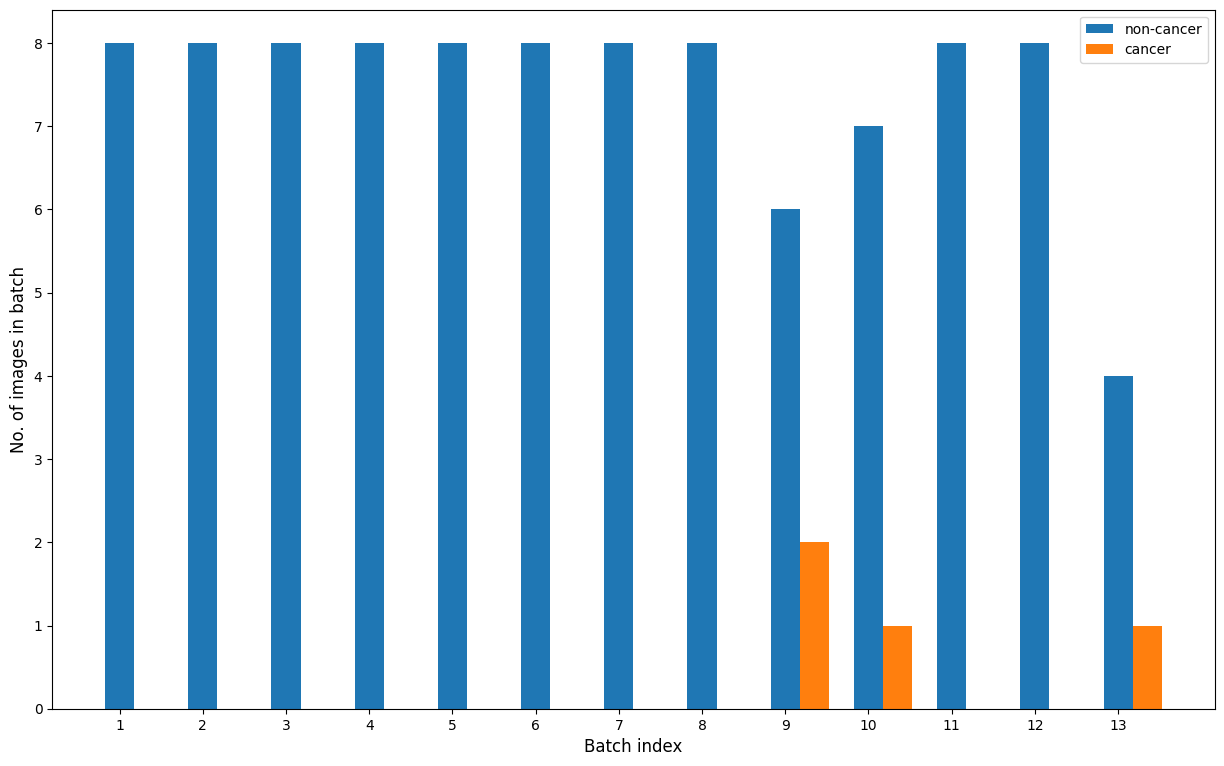

Avg Proportion of non-cancer per batch: 0.7461538461538463
Avg Proportion of cancer per batch: 0.03076923076923077


In [30]:
from torch.utils.data import TensorDataset, DataLoader

check_dl = laoder_check.reset_index(drop=True)
label_to_id = {v: idx for idx, v in enumerate (check_dl.cancer.unique())}
ds = TensorDataset(torch.as_tensor([ (idx, label_to_id[l]) for idx, l in enumerate (check_dl.cancer.values)]))
dl = DataLoader(ds, shuffle=True, batch_size=8)
class_0_batch_counts, class_1_batch_counts, idxs_seen = visualise_dataloader(dl,{0:'non-cancer',1:'cancer'})

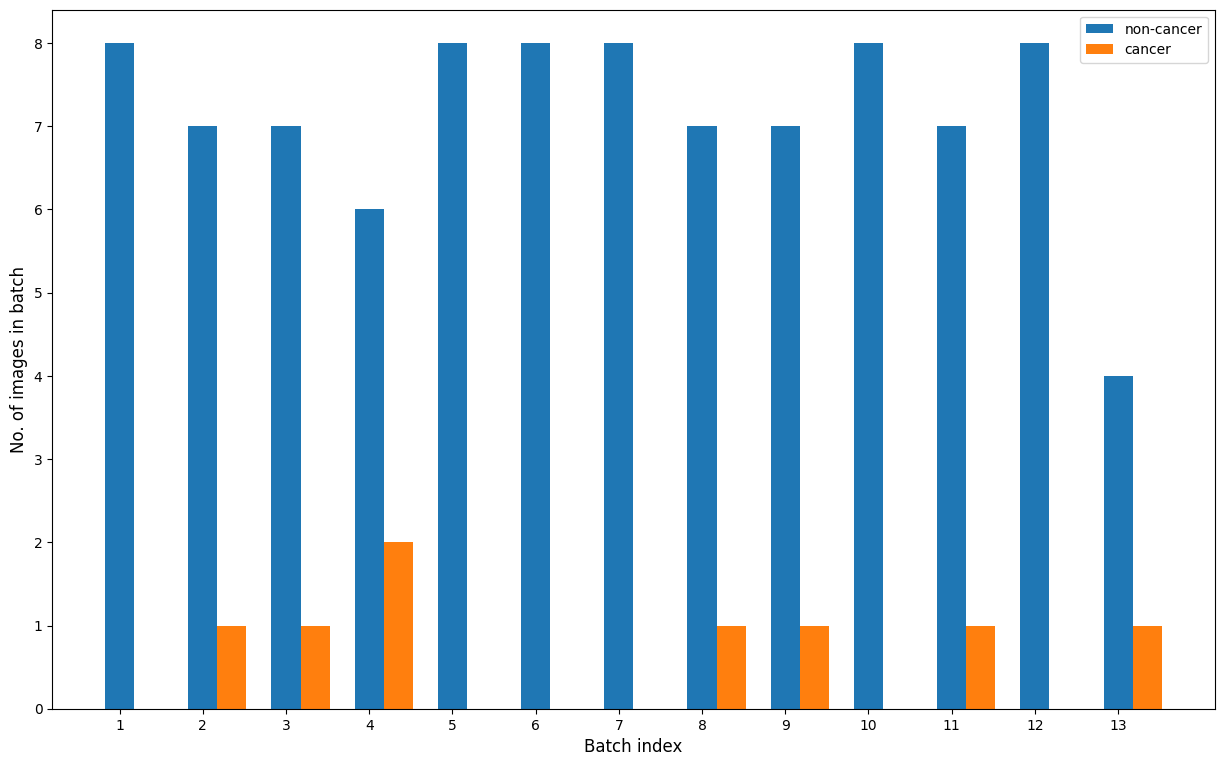

Avg Proportion of non-cancer per batch: 0.7153846153846154
Avg Proportion of cancer per batch: 0.061538461538461535


In [31]:
check_dl = laoder_check.reset_index(drop=True)
label_to_id = {v: idx for idx, v in enumerate (check_dl.cancer.unique())}
ds = TensorDataset(torch.as_tensor([ (idx, label_to_id[l]) for idx, l in enumerate (check_dl.cancer.values)]))
sampler = ExhaustiveWeightedRandomSampler(laoder_check.weight.tolist(), len(check_dl))
dl = DataLoader(ds, batch_size=8,sampler=sampler)
class_0_batch_counts, class_1_batch_counts, idxs_seen = visualise_dataloader(dl,{0:'non-cancer',1:'cancer'})

In [21]:
cc = next(iter(train_dataloader))

In [22]:
cc['image'].shape

torch.Size([8, 3, 512, 512])

In [23]:
cc['image_id']

tensor([ 102733848, 1234933874,  809479419, 1640274067, 2129119612, 1260162631,
         294168046,  503361456])

In [24]:
cc.keys()

dict_keys(['image', 'image_id', 'target', 'meta'])

In [25]:
cc['image'].shape

torch.Size([8, 3, 512, 512])

In [129]:
cc['image'][1].shape

torch.Size([3, 1024, 1024])

In [106]:
# plt.imshow(cc['image'][3].permute(1,2,0).detach().cpu().numpy()[:,:,1])

In [23]:
check_img = cv2.imread('input_data/train_image_dcm_converted/10011/1031443799.png')

In [24]:
check_img.shape

(2776, 2082, 3)

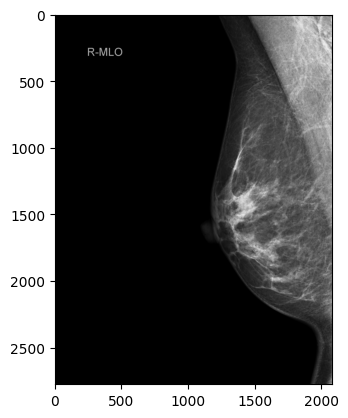

In [25]:
plt.imshow(check_img)

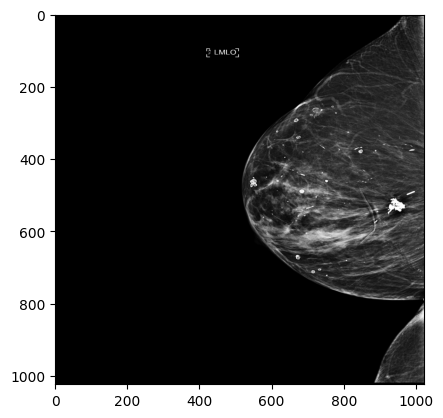

In [47]:
plt.imshow(cc['image'][0].permute(1,2,0).detach().cpu().numpy())

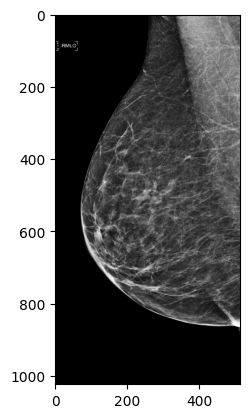

In [912]:
plt.imshow(cc['image'][3].permute(1,2,0).detach().cpu().numpy())

In [1220]:
cc['image'][3].permute(1,2,0).detach().cpu().numpy().shape

RuntimeError: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 4 is not equal to len(dims) = 3

In [824]:
d_2_5_image =cc['image'][3].permute(1,2,0).detach().cpu().numpy()

In [825]:
d_2_5_image[:,:,1] = cc['image'][4].permute(1,2,0).detach().cpu().numpy()[:,:,1]

In [826]:
d_2_5_image[:,:,:2].shape

(1024, 512, 2)

In [827]:
a = ( d_2_5_image[:,:,1] == d_2_5_image[:,:,0])

In [828]:
a

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

## MODEL ARCHITECTURE TESTING

In [19]:
import timm
import torch.nn as nn
import torch.nn.functional as F
from timm import create_model
import torch.nn.functional as F
from torch.nn.parameter import Parameter

In [22]:
class EffNetNetwork(torch.nn.Module):
    def __init__(self, output_size, no_columns):
        super().__init__()
        self.no_columns, self.output_size = no_columns, output_size
        
        # Define Feature part (IMAGE)
        # self.features = EfficientNet.from_pretrained('efficientnet-b2')
        self.features =  timm.create_model(
        'efficientnet_b2',
        pretrained=True,
        num_classes=1,
        drop_rate=0.2)
        
        # (CSV)
        self.csv = torch.nn.Sequential(torch.nn.Linear(self.no_columns, 250),
                                 torch.nn.BatchNorm1d(250),
                                 torch.nn.ReLU(),
                                 torch.nn.Dropout(p=0.2),
                                 
                                 torch.nn.Linear(250, 250),
                                 torch.nn.BatchNorm1d(250),
                                 torch.nn.ReLU(),
                                 torch.nn.Dropout(p=0.2))
        
        # Define Classification part
        self.classification = torch.nn.Sequential(torch.nn.Linear(1408 + 250, self.output_size))
        
        
    def forward(self, image, meta, target= None, prints=True):   
        
        if prints: print('Input Image shape:', image.shape, '\n'+
                         'Input metadata shape:', meta.shape)
        
        
        # Image CNN
        # image = self.features(image.float())
        image = self.features.forward_features(image.float())
        
        image = F.avg_pool2d(image, image.size()[2:]).reshape(-1, 1408)
        if prints: print('Features Image shape:', image.shape)
        
        # CSV FNN
        meta = self.csv(meta.float())
        if prints: print('Meta Data:', meta.shape)
            
        # Concatenate layers from image with layers from csv_data
        image_meta_data = torch.cat((image, meta), dim=1)
        if prints: print('Concatenated Data:', image_meta_data.shape)
        
        # CLASSIF
        out = self.classification(image_meta_data)
        if prints: print('Out shape:', out.shape)
        
        loss = None
        if target is not None:
            if prints: print("Target shape",target.shape , ">>>",target.unsqueeze(1).float().shape)
            loss = loss_fn(out, target.unsqueeze(1).float(),use_weights=False)
            out = torch.sigmoid(out)

        return out, loss

def loss_fn(output, target, use_weights=False):
    if use_weights:
        return torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)(output, target)
    else:
        return torch.nn.BCEWithLogitsLoss()(output, target)
    

In [20]:
class RSNAModelWithFFT(torch.nn.Module):
    def __init__(self, output_size, n_cols, pos_weight=None):
        super().__init__()
        self.no_columns, self.output_size = n_cols, output_size
        self.features = timm.create_model('efficientnet_b4',pretrained=True)
        self.dropout = nn.Dropout(0.1)  
        
        # Image features head
        self.classification = nn.Linear(1792, 1)
        
        # FFT features head
        self.rfft = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu1 = nn.ReLU(inplace=True)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.flatten = nn.Flatten(start_dim=1) # modify flatten operation
        self.fc0 = nn.Linear(8*1024*1024, 1024)
        self.dropout1 = nn.Dropout(p=0.5)
        self.fc1 = nn.Linear(1024, 512)
        self.dropout2 = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(512, 1)
        
        # Multi-head attention
        self.multihead_attn = nn.MultiheadAttention(1024, num_heads=8)
        self.norm1 = nn.LayerNorm([1024, 1, 1])
        self.dropout3 = nn.Dropout(0.1)
        self.norm2 = nn.LayerNorm([1024, 1, 1])
        
    def forward(self, image, meta=None, target=None, image_id=None):
        # Image features
        x_img = image
        features = self.features.forward_features(x_img.float())
        x_img = F.adaptive_avg_pool2d(features, 1)
        x_img = torch.flatten(x_img, 1, 3)
        x_img = self.dropout(x_img)
        out_img = self.classification(x_img)
        
        # FFT features
        x_fft = image.float().mean(dim=1, keepdim=True)
        x_fft = self.rfft(x_fft.float())
        x_fft = self.bn1(x_fft)
        x_fft = self.relu1(x_fft)
        x_fft = self.maxpool1(x_fft)
        print(x_fft.shape,">>>>")
        x_fft = self.flatten(x_fft)
        print(x_fft.shape,">>444>>")
        x_fft = self.fc1(x_fft)
        x_fft = self.dropout2(x_fft)
        out_fft = self.fc2(x_fft)
        
        # Multi-head attention
        x = torch.cat((x_img, x_fft), dim=1)
        x = x.transpose(0, 1)
        x, _ = self.multihead_attn(x, x, x)
        x = self.norm1(x)
        x = self.dropout3(x)
        x = x.transpose(0, 1)
        x = x + x_img + x_fft
        x = self.norm2(x)
        
        out = self.classification(x)
        
        loss = None
        if target is not None:
            if prints: print("Target shape",target.shape , ">>>",target.unsqueeze(1).float().shape)
            loss = loss_fn(out, target.unsqueeze(1).float(),use_weights=False)
            out = torch.sigmoid(out)

        return out, loss

def loss_fn(output, target, use_weights=False):
    if use_weights:
        return torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)(output, target)
    else:
        return torch.nn.BCEWithLogitsLoss()(output, target)
    

    
    


In [55]:
cc['meta']

tensor([[ 2.,  0.,  1.,  0., 29., 67.],
        [ 2.,  0.,  0.,  0., 48., 60.],
        [ 1.,  0.,  0.,  0., 49., 71.],
        [ 2.,  1.,  1.,  0., 29., 73.],
        [ 2.,  1.,  1.,  0., 48., 57.],
        [ 2.,  0.,  1.,  0., 21., 55.],
        [ 2.,  0.,  0.,  0., 29., 62.],
        [ 1.,  1.,  0.,  0., 93., 51.]], dtype=torch.float64)

In [67]:
class RSNAModelWithFFT(nn.Module):
    def __init__(self, num_classes=1):
        super(RSNAModelWithFFT, self).__init__()

        # Features for the image branch
        self.features = timm.create_model('efficientnet_b4',pretrained=True)
        self.dropout = nn.Dropout(0.1)  

        # Features for the metadata branch
        self.fc1_meta = nn.Linear(6, 32)
        self.dropout1_meta = nn.Dropout(0.5)
        self.relu1_meta = nn.ReLU(inplace=True)

        # Features for the combined branch
        self.fc1 = nn.Linear(8*13*13 + 32, 1024)
        self.dropout2 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(1024, num_classes)

        # FFT layer
        self.fft = nn.Conv2d(2, 16, kernel_size=3, stride=1, padding=1)
        self.bn_fft = nn.BatchNorm2d(16)
        self.relu_fft = nn.ReLU(inplace=True)
        self.maxpool_fft = nn.MaxPool2d(kernel_size=2)
        self.flatten = nn.Flatten()

    def forward(self, image, meta=None, target=None, image_id=None):
        # Image branch
        x_img = image
        features = self.features.forward_features(x_img.float())
        x_img = F.adaptive_avg_pool2d(features, 1)
        x_img = torch.flatten(x_img, 1, 3)
        x_img = self.dropout(x_img)
        print(x_img.shape,"image branch")

        # Metadata branch
        meta = self.fc1_meta(meta)
        meta = self.dropout1_meta(meta)
        meta = self.relu1_meta(meta)
        print(meta.shape , "meta branch")

        # FFT branch
        x_fft = torch.fft.fft2(image.float(), dim=(-2,-1)).unsqueeze(1)
        x_fft = torch.stack([x_fft.real, x_fft.imag], dim=1)
        x_fft = self.fft(x_fft)
        x_fft = self.bn_fft(x_fft)
        x_fft = self.relu_fft(x_fft)
        x_fft = self.maxpool_fft(x_fft)
        x_fft = self.flatten(x_fft)
        print(x_fft.shape , "FFT branch")

        # Combined branch
        x = torch.cat([x, x_fft, meta], dim=1)
        x = self.fc1(x)
        x = self.dropout2(x)
        out = self.fc2(x)

        loss = None
        if target is not None:
            if prints: print("Target shape",target.shape , ">>>",target.unsqueeze(1).float().shape)
            loss = loss_fn(out, target.unsqueeze(1).float(),use_weights=False)
            out = torch.sigmoid(out)

        return out, loss

def loss_fn(output, target, use_weights=False):
    if use_weights:
        return torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)(output, target)
    else:
        return torch.nn.BCEWithLogitsLoss()(output, target)

In [68]:
model = RSNAModelWithFFT()

In [1]:
cc['meta'].shape

NameError: name 'cc' is not defined

In [ ]:
# Outputs
out, loss1 = model(image=cc['image'],meta=cc['meta'],target=cc['target'])

In [31]:
cc['target']

tensor([0, 0, 1, 0, 0, 0, 0, 0])

In [29]:
cc['image'][:2,:,:,:].shape

torch.Size([2, 3, 2048, 1024])

In [ ]:
cc['image'][:,1,:,:].aha

torch.Size([8, 2048, 1024])

In [32]:
cc['image'].float().mean(dim=1, keepdim=True).shape

torch.Size([8, 1, 2048, 1024])

In [46]:
config ={"MODEL_TYPE":"efficientnet_b2"}

In [47]:
config['MODEL_TYPE']

'efficientnet_b2'

In [49]:
# class RSNAModel(torch.nn.Module):
#     def __init__(self, aux_classes, model_type=config['MODEL_TYPE'], dropout=0.):
#         super().__init__()
#         self.model = create_model(model_type, pretrained=True, num_classes=0, drop_rate=dropout)

#         self.backbone_dim = self.model(torch.randn(1, 3, 512, 512)).shape[-1]

#         self.nn_cancer = torch.nn.Sequential(
#             torch.nn.Linear(self.backbone_dim, 1),
#         )
#         self.nn_aux = torch.nn.ModuleList([
#             torch.nn.Linear(self.backbone_dim, int(n)) for n in aux_classes])

#     def forward(self, x):
#         # returns logits
#         x = self.model(x)

#         cancer = self.nn_cancer(x).squeeze()
#         aux = []
#         for nn in self.nn_aux:
#             aux.append(nn(x).squeeze())
#         return cancer, aux

#     def predict(self, x):
#         cancer, aux = self.forward(x)
#         sigaux = []
#         for a in aux:
#             sigaux.append(torch.softmax(a, dim=-1))
#         return torch.sigmoid(cancer), sigaux


In [50]:
# model = create_model( 'efficientnet_b4', pretrained=True, num_classes=0, drop_rate=0.1)

# backbone_dim = model(torch.randn(1, 3, 512, 512)).shape[-1]



In [38]:
# model = RSNAModel(AUX_TARGET_NCLASSES, model_type='efficientnet_b4')
# pred, aux = model.predict(torch.randn(2, 3, 512, 512))

In [85]:
all_densenet_models = timm.list_models('*seresnext*')

In [5]:
all_densenet_models = timm.list_models('*effi*')

In [6]:
# all_densenet_models

['efficientformer_l1',
 'efficientformer_l3',
 'efficientformer_l7',
 'efficientnet_b0',
 'efficientnet_b0_g8_gn',
 'efficientnet_b0_g16_evos',
 'efficientnet_b0_gn',
 'efficientnet_b1',
 'efficientnet_b1_pruned',
 'efficientnet_b2',
 'efficientnet_b2_pruned',
 'efficientnet_b2a',
 'efficientnet_b3',
 'efficientnet_b3_g8_gn',
 'efficientnet_b3_gn',
 'efficientnet_b3_pruned',
 'efficientnet_b3a',
 'efficientnet_b4',
 'efficientnet_b5',
 'efficientnet_b6',
 'efficientnet_b7',
 'efficientnet_b8',
 'efficientnet_cc_b0_4e',
 'efficientnet_cc_b0_8e',
 'efficientnet_cc_b1_8e',
 'efficientnet_el',
 'efficientnet_el_pruned',
 'efficientnet_em',
 'efficientnet_es',
 'efficientnet_es_pruned',
 'efficientnet_l2',
 'efficientnet_lite0',
 'efficientnet_lite1',
 'efficientnet_lite2',
 'efficientnet_lite3',
 'efficientnet_lite4',
 'efficientnetv2_l',
 'efficientnetv2_m',
 'efficientnetv2_rw_m',
 'efficientnetv2_rw_s',
 'efficientnetv2_rw_t',
 'efficientnetv2_s',
 'efficientnetv2_xl',
 'gc_efficientnet

In [86]:
all_densenet_models

['gluon_seresnext50_32x4d',
 'gluon_seresnext101_32x4d',
 'gluon_seresnext101_64x4d',
 'legacy_seresnext26_32x4d',
 'legacy_seresnext50_32x4d',
 'legacy_seresnext101_32x4d',
 'seresnext26d_32x4d',
 'seresnext26t_32x4d',
 'seresnext26tn_32x4d',
 'seresnext26ts',
 'seresnext50_32x4d',
 'seresnext101_32x4d',
 'seresnext101_32x8d',
 'seresnext101d_32x8d',
 'seresnextaa101d_32x8d']

In [55]:
# image = EfficientNet.from_pretrained('efficientnet-b2').extract_features(cc['image'].float())
# image = F.avg_pool2d(image, image.size()[2:]).reshape(-1, 1408)

Loaded pretrained weights for efficientnet-b2


In [27]:
 cc['image'].shape

torch.Size([8, 3, 2048, 1024])

In [42]:
features_mod =  timm.create_model(
        'seresnext50_32x4d',
        pretrained=True,
        num_classes=1,
        drop_rate=0.2)

# classification = nn.Linear(1408,1)

In [43]:
features_mod.num_features

2048

In [6]:
features_mod.feature_info[-1]['num_chs']

2048

In [66]:
csv_columns = ['laterality', 'view', 'age', 'implant']
no_columns = len(csv_columns)
output_size = 1

In [713]:
cc['target'].unsqueeze(1).float().shape

torch.Size([8, 1])

In [28]:
import torch.nn as nn

In [42]:
IN_CHANNELS = 1
MODEL_BACKBONE = 'seresnext50_32x4d'

In [119]:
    
def gem(x, p=3, eps=1e-6):
    return F.avg_pool2d(x.clamp(min=eps).pow(p), (x.size(-2), x.size(-1))).pow(1.0 / p)


class GeM(nn.Module):
    def __init__(self, p=3, eps=1e-6, p_trainable=False):
        super(GeM, self).__init__()
        if p_trainable:
            self.p = Parameter(torch.ones(1) * p)
        else:
            self.p = p
        self.eps = eps

    def forward(self, x):
        ret = gem(x, p=self.p, eps=self.eps)
        return ret

    def __repr__(self):
        return (self.__class__.__name__  + f"(p={self.p.data.tolist()[0]:.4f},eps={self.eps})")



class Net(nn.Module):

    def __init__(self, output_size, n_cols,pos_weight=None):
        super().__init__()
        self.no_columns, self.output_size = n_cols, output_size
        self.use_weights = False if pos_weight is None else True 
        self.pos_weight =  torch.tensor(pos_weight) if self.use_weights else None
        self.backbone = timm.create_model(MODEL_BACKBONE, 
                                          pretrained=True, 
                                          num_classes=0, 
                                          global_pool="", 
                                          in_chans=IN_CHANNELS)
    
        backbone_out = self.backbone.feature_info[-1]['num_chs']

        self.global_pool = GeM(p_trainable=True)
        self.head = torch.nn.Linear(backbone_out, self.output_size)
        self.loss_fn = nn.BCEWithLogitsLoss()

    def forward(self,image, meta=None,target=None,image_id=None):

        x = image.float()

        x = self.backbone(x)
        x = self.global_pool(x)
        x = x[:,:,0,0]

        out = self.head(x)
        
        
        loss = None
        if target is not None:
            loss = self.loss_fn(out, target.unsqueeze(1).float(), use_weights=self.use_weights)
            out = torch.sigmoid(out)
        
        return out, loss
        
    def loss_fn(self, output, target, use_weights=False):
        if use_weights:
            return torch.nn.BCEWithLogitsLoss(pos_weight=self.pos_weight)(output, target)
        else:
            return torch.nn.BCEWithLogitsLoss()(output, target)



In [46]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SpatialTransformer(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size):
        super(SpatialTransformer, self).__init__()

        # Define the localization network
        self.loc_net = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size),
            nn.ReLU(True),
            nn.Conv2d(out_channels, out_channels, kernel_size),
            nn.ReLU(True)
        )

        # Initialize the matrix for the transformation
        self.trans_matrix = nn.Parameter(torch.eye(3, dtype=torch.float32))

    def forward(self, x):
        # Generate the parameters for the transformation
        theta = self.loc_net(x)
        theta = theta.view(-1, 2, 3)
        theta = torch.cat([theta, self.trans_matrix[:2, 2:]], dim=1)

        # Apply the transformation to the input image
        grid = F.affine_grid(theta, x.size(), align_corners=True)
        x = F.grid_sample(x, grid, align_corners=True)

        return x


    
def gem(x, p=3, eps=1e-6):
    return F.avg_pool2d(x.clamp(min=eps).pow(p), (x.size(-2), x.size(-1))).pow(1.0 / p)


class GeM(nn.Module):
    def __init__(self, p=3, eps=1e-6, p_trainable=False):
        super(GeM, self).__init__()
        if p_trainable:
            self.p = Parameter(torch.ones(1) * p)
        else:
            self.p = p
        self.eps = eps

    def forward(self, x):
        ret = gem(x, p=self.p, eps=self.eps)
        return ret

    def __repr__(self):
        return (self.__class__.__name__  + f"(p={self.p.data.tolist()[0]:.4f},eps={self.eps})")
    
    
class Net(nn.Module):

    def __init__(self, output_size, n_cols,pos_weight=None):
        super().__init__()
        self.no_columns, self.output_size = n_cols, output_size
        self.use_weights = False if pos_weight is None else True 
        self.pos_weight =  torch.tensor(pos_weight) if self.use_weights else None
        self.spatial_transformer = SpatialTransformer(3, 64, kernel_size=3)
        self.backbone = timm.create_model(MODEL_BACKBONE, 
                                          pretrained=True, 
                                          num_classes=0, 
                                          global_pool="", 
                                          in_chans=IN_CHANNELS)
    
        backbone_out = self.backbone.feature_info[-1]['num_chs']

        self.global_pool = GeM(p_trainable=True)
        self.head = torch.nn.Linear(backbone_out, self.output_size)
        self.loss_fn = nn.BCEWithLogitsLoss()

    def forward(self,image, meta=None,target=None,image_id=None):

        x = image.float()
        s = self.spatial_transformer(x)
        print(s.shape)

        x = self.backbone(x)
        x = self.global_pool(x)
        x = x[:,:,0,0]
        print(x.shape)
        x =  torch.cat([x,s])
        out = self.head(x)
        
        
        loss = None
        if target is not None:
            loss = self.loss_fn(out, target.unsqueeze(1).float(), use_weights=self.use_weights)
            out = torch.sigmoid(out)
        
        return out, loss
        
    def loss_fn(self, output, target, use_weights=False):
        if use_weights:
            return torch.nn.BCEWithLogitsLoss(pos_weight=self.pos_weight)(output, target)
        else:
            return torch.nn.BCEWithLogitsLoss()(output, target)

    


In [47]:
cc['image'].shape

torch.Size([8, 3, 2048, 1024])

In [48]:
model = Net(1,n_cols=6)

In [49]:
# Outputs
out, loss1 = model(image=cc['image'],target=cc['target'])

RuntimeError: Tensors must have same number of dimensions: got 3 and 2

In [123]:
loss1

tensor(1.1005, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)

In [51]:
import torch
import torch.nn as nn
import torch.nn.functional as F






class RSNAModel(torch.nn.Module):
    def __init__(self, output_size, n_cols,pos_weight=None):
        super().__init__()
        self.no_columns, self.output_size = n_cols, output_size
        self.use_weights = False if pos_weight is None else True 
        self.pos_weight =  torch.tensor(pos_weight) if self.use_weights else None
        self.register_buffer('mean', torch.FloatTensor([0.5, 0.5, 0.5]).reshape(1, 3, 1, 1))
        self.register_buffer('std', torch.FloatTensor([0.5, 0.5, 0.5]).reshape(1, 3, 1, 1))
        
        
        # Define Feature part (IMAGE)
        # self.features = EfficientNet.from_pretrained(config.MODEL_BACKBONE)
        self.features = create_model( 'seresnext50_32x4d', pretrained=True, num_classes=0) 
        
        
        
        # (CSV)
#         self.csv = torch.nn.Sequential(torch.nn.Linear(self.no_columns, 250),
#                                  torch.nn.BatchNorm1d(250),
#                                  torch.nn.ReLU(),
#                                  torch.nn.Dropout(p=0.2),
                                 
#                                  torch.nn.Linear(250, 250),
#                                  torch.nn.BatchNorm1d(250),
#                                  torch.nn.ReLU(),
#                                  torch.nn.Dropout(p=0.2))
        
        # Define Classification part
        # self.classification = torch.nn.Sequential(torch.nn.Linear(1408 + 250, self.output_size))
        self.classification = nn.Linear(1792,1)
        
        
    def forward(self, image, meta,target=None,image_id=None,prints=True):   
        if prints: print('Input Image shape:', image.shape, '\n'+
                         'Input metadata shape:', meta.shape)
        
        
        # Image CNN
        x = image
        batch_size,C,H,W = x.shape
        x = (x - self.mean) / self.std
        # image = self.features.extract_features(image.float())
        features = self.features.forward_features(x.float())
        if prints: print('Features Forward Image shape:', image.shape)
        
        x = F.adaptive_avg_pool2d(features,1)
        if prints: print('Features ADaptive pool Image shape:', x.shape)
        x = torch.flatten(x,1,3)
        if prints: print('Flatten Data:', x.shape)

        
        # CLASSIF
        out = self.classification(x)
        if prints: print('Out shape:', out.shape)
        
        loss = None
        if target is not None:
            loss = self.loss_fn(out, target.unsqueeze(1).float(), use_weights=self.use_weights)
            # out = torch.sigmoid(out)
        
        return out, loss
        
    def loss_fn(self, output, target, use_weights=False):
        if use_weights:
            return torch.nn.BCEWithLogitsLoss(pos_weight=self.pos_weight)(output, target)
        else:
            return torch.nn.BCEWithLogitsLoss()(output, target)

    

In [52]:
model = RSNAModel(1,n_cols=6)

In [53]:
# Outputs
out, loss1 = model(cc['image'], cc['meta'], cc['target'],prints=True)

# Criterion example
criterion_example = torch.nn.BCEWithLogitsLoss()
# Unsqueeze(1) from shape=[3] to shape=[3, 1]
loss = criterion_example(out, cc['target'].unsqueeze(1).float()) 
print("="*50)
print('Loss:', loss.item())

Input Image shape: torch.Size([8, 3, 512, 512]) 
Input metadata shape: torch.Size([8, 6])
Features Forward Image shape: torch.Size([8, 3, 512, 512])
Features ADaptive pool Image shape: torch.Size([8, 1792, 1, 1])
Flatten Data: torch.Size([8, 1792])
Out shape: torch.Size([8, 1])
Loss: 0.7040934562683105


In [70]:
predictions, true_vals = [], []
sigmoid_output = []
for data in tqdm(train_dataloader, total=len(train_dataloader)):
    
    out, loss1 = model(cc['image'], cc['meta'], cc['target'],prints=False)
    sigmoid_output.append(torch.sigmoid(out).detach().cpu().numpy()[:,0])
    predictions.append(torch.sigmoid(out).detach().cpu().numpy())
    true_vals.append(cc['target'].detach().cpu())
# predictions = np.concatenate(predictions, axis=0)
# sigmoid_output = np.concatenate(sigmoid_output, axis=0)

    


100%|██████████| 13/13 [00:58<00:00,  4.54s/it]


In [26]:
# Outputs
out, loss1 = model(cc['image'], cc['meta'], cc['target'],prints=True)

# Criterion example
criterion_example = torch.nn.BCEWithLogitsLoss()
# Unsqueeze(1) from shape=[3] to shape=[3, 1]
loss = criterion_example(out, cc['target'].unsqueeze(1).float()) 
print("="*50)
print('Loss:', loss.item())

Input Image shape: torch.Size([8, 3, 2048, 1024]) 
Input metadata shape: torch.Size([8, 6])
Features Forward Image shape: torch.Size([8, 3, 2048, 1024])
Features ADaptive pool Image shape: torch.Size([8, 1792, 1, 1])
Flatten Data: torch.Size([8, 1792])
Out shape: torch.Size([8, 1])
Loss: 1.0208165645599365


In [99]:
cc['image'].shape

torch.Size([8, 3, 2048, 1024])

In [100]:
model_hn = EffB4Net()

In [101]:
hng_model = model_hn.forward(cc['image'])

In [102]:
hng_model.shape

torch.Size([8])

#### different image shape

In [69]:
# Outputs
out, loss1 = model(cc['image'], cc['meta'], cc['target'],prints=True)

# Criterion example
criterion_example = torch.nn.BCEWithLogitsLoss()
# Unsqueeze(1) from shape=[3] to shape=[3, 1]
loss = criterion_example(out, cc['target'].unsqueeze(1).float()) 
print("="*50)
print('Loss:', loss.item())

Input Image shape: torch.Size([8, 3, 2048, 1024]) 
Input metadata shape: torch.Size([8, 6])
Features Image shape: torch.Size([8, 1408])
Meta Data: torch.Size([8, 250])
Concatenated Data: torch.Size([8, 1658])
Out shape: torch.Size([8, 1])
Target shape torch.Size([8]) >>> torch.Size([8, 1])
Loss: 0.7189445495605469


#### different image shape

In [167]:
# Outputs
out, loss1 = model(cc['image'], cc['meta'], cc['target'],prints=True)

# Criterion example
criterion_example = torch.nn.BCEWithLogitsLoss()
# Unsqueeze(1) from shape=[3] to shape=[3, 1]
loss = criterion_example(out, cc['target'].unsqueeze(1).float()) 
print("="*50)
print('Loss:', loss.item())

Input Image shape: torch.Size([11, 3, 2048, 1024]) 
Input metadata shape: torch.Size([11, 6])
Features Image shape: torch.Size([11, 1408])
Meta Data: torch.Size([11, 250])
Concatenated Data: torch.Size([11, 1658])
Out shape: torch.Size([11, 1])
Target shape torch.Size([11]) >>> torch.Size([11, 1])
Loss: 0.7038346529006958


## COATNET

In [24]:
def conv_3x3_bn(inp, oup, image_size, downsample=False):
    stride = 1 if downsample == False else 2
    return nn.Sequential(
        nn.Conv2d(inp, oup, 3, stride, 1, bias=False),
        nn.BatchNorm2d(oup),
        nn.GELU()
    )

class PreNorm(nn.Module):
    def __init__(self, dim, fn, norm):
        super().__init__()
        self.norm = norm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

class SE(nn.Module):
    def __init__(self, inp, oup, expansion=0.25):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(oup, int(inp * expansion), bias=False),
            nn.GELU(),
            nn.Linear(int(inp * expansion), oup, bias=False),
            nn.Sigmoid())
    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout=0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout))
    def forward(self, x):
        return self.net(x)


class MBConv(nn.Module):
    def __init__(self, inp, oup, image_size, downsample=False, expansion=4):
        super().__init__()
        self.downsample = downsample
        stride = 1 if self.downsample == False else 2
        hidden_dim = int(inp * expansion)

        if self.downsample:
            self.pool = nn.MaxPool2d(3, 2, 1)
            self.proj = nn.Conv2d(inp, oup, 1, 1, 0, bias=False)

        if expansion == 1:
            self.conv = nn.Sequential(
                nn.Conv2d(hidden_dim, hidden_dim, 3, stride, 1, groups=hidden_dim, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.GELU(),
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup))
        else:
            self.conv = nn.Sequential(
                nn.Conv2d(inp, hidden_dim, 1, stride, 0, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.GELU(),                
                nn.Conv2d(hidden_dim, hidden_dim, 3, 1, 1, groups=hidden_dim, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.GELU(),
                SE(inp, hidden_dim),
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup))
        
        self.conv = PreNorm(inp, self.conv, nn.BatchNorm2d)

    def forward(self, x):
        if self.downsample: return self.proj(self.pool(x)) + self.conv(x)
        else: return x + self.conv(x)

class Attention(nn.Module):
    def __init__(self, inp, oup, image_size, heads=8, dim_head=32, dropout=0.):
        super().__init__()
        inner_dim = dim_head * heads
        project_out = not (heads == 1 and dim_head == inp)
        self.ih, self.iw = image_size
        self.heads = heads
        self.scale = dim_head ** -0.5       
        self.relative_bias_table = nn.Parameter(
            torch.zeros((2 * self.ih - 1) * (2 * self.iw - 1), heads))
        coords = torch.meshgrid((torch.arange(self.ih), torch.arange(self.iw)))
        coords = torch.flatten(torch.stack(coords), 1)
        relative_coords = coords[:, :, None] - coords[:, None, :]
        relative_coords[0] += self.ih - 1
        relative_coords[1] += self.iw - 1
        relative_coords[0] *= 2 * self.iw - 1
        relative_coords = rearrange(relative_coords, 'c h w -> h w c')
        relative_index = relative_coords.sum(-1).flatten().unsqueeze(1)
        self.register_buffer("relative_index", relative_index)
        self.attend = nn.Softmax(dim=-1)
        self.to_qkv = nn.Linear(inp, inner_dim * 3, bias=False)
        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, oup),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x):
        qkv = self.to_qkv(x).chunk(3, dim=-1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h=self.heads), qkv)
        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale
        relative_bias = self.relative_bias_table.gather(0, self.relative_index.repeat(1, self.heads))
        relative_bias = rearrange(relative_bias, '(h w) c -> 1 c h w', h=self.ih*self.iw, w=self.ih*self.iw)
        dots = dots + relative_bias
        attn = self.attend(dots)
        out = torch.matmul(attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        out = self.to_out(out)
        return out

class Transformer(nn.Module):
    def __init__(self, inp, oup, image_size, heads=8, dim_head=32, downsample=False, dropout=0.):
        super().__init__()
        hidden_dim = int(inp * 4)
        self.ih, self.iw = image_size
        self.downsample = downsample
        if self.downsample:
            self.pool1 = nn.MaxPool2d(3, 2, 1)
            self.pool2 = nn.MaxPool2d(3, 2, 1)
            self.proj = nn.Conv2d(inp, oup, 1, 1, 0, bias=False)
        self.attn = Attention(inp, oup, image_size, heads, dim_head, dropout)
        self.ff = FeedForward(oup, hidden_dim, dropout)
        self.attn = nn.Sequential(
            Rearrange('b c ih iw -> b (ih iw) c'),
            PreNorm(inp, self.attn, nn.LayerNorm),
            Rearrange('b (ih iw) c -> b c ih iw', ih=self.ih, iw=self.iw))
        self.ff = nn.Sequential(
            Rearrange('b c ih iw -> b (ih iw) c'),
            PreNorm(oup, self.ff, nn.LayerNorm),
            Rearrange('b (ih iw) c -> b c ih iw', ih=self.ih, iw=self.iw))

    def forward(self, x):
        if self.downsample: x = self.proj(self.pool1(x)) + self.attn(self.pool2(x))
        else: x = x + self.attn(x)
        x = x + self.ff(x)
        return x


class CoAtNet(nn.Module):
    def __init__(self, image_size, in_channels, num_blocks, channels, num_classes=1000, block_types=['C', 'C', 'T', 'T']):
        super().__init__()
        ih, iw = image_size
        block = {'C': MBConv, 'T': Transformer}

        self.s0 = self._make_layer(
            conv_3x3_bn, in_channels, channels[0], num_blocks[0], (ih // 2, iw // 2))
        self.s1 = self._make_layer(
            block[block_types[0]], channels[0], channels[1], num_blocks[1], (ih // 4, iw // 4))
        self.s2 = self._make_layer(
            block[block_types[1]], channels[1], channels[2], num_blocks[2], (ih // 8, iw // 8))
        self.s3 = self._make_layer(
            block[block_types[2]], channels[2], channels[3], num_blocks[3], (ih // 16, iw // 16))
        self.s4 = self._make_layer(
            block[block_types[3]], channels[3], channels[4], num_blocks[4], (ih // 32, iw // 32))

        self.pool = nn.AvgPool2d(ih // 32, 1)
        self.fc = nn.Linear(channels[-1], num_classes, bias=False)

    def forward(self, x):
        x = self.s0(x)
        x = self.s1(x)
        x = self.s2(x)
        x = self.s3(x)
        x = self.s4(x)

        x = self.pool(x).view(-1, x.shape[1])
        x = self.fc(x)
        return x

    def _make_layer(self, block, inp, oup, depth, image_size):
        layers = nn.ModuleList([])
        for i in range(depth):
            if i == 0:
                layers.append(block(inp, oup, image_size, downsample=True))
            else:
                layers.append(block(oup, oup, image_size))
        return nn.Sequential(*layers)


In [28]:
import string
import joblib
import tifffile
# import seaborn as sns
from random import randint
from einops import rearrange
from torchvision import models
from einops.layers.torch import Rearrange

In [29]:
num_blocks = [2, 2, 12, 28, 2]
channels = [64, 64, 128, 256, 512]
model = CoAtNet((2048, 1024), 1, num_blocks, channels, num_classes=2)

/home/workspace/.local/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [30]:
device =torch.device("cuda:15" if torch.cuda.is_available() else "cpu")

In [31]:
model.cuda(device)  

CoAtNet(
  (s0): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): GELU(approximate='none')
    )
    (1): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): GELU(approximate='none')
    )
  )
  (s1): Sequential(
    (0): MBConv(
      (pool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (proj): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (conv): PreNorm(
        (norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (fn): Sequential(
          (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(2, 2), bias=False)
          (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, 

In [34]:
cc['image'][:1,:1,:,:].shape

torch.Size([1, 1, 512, 512])

In [35]:
# Outputs
out = model(cc['image'][:2,:1,:,:].float().to(device))


RuntimeError: The size of tensor a (1024) must match the size of tensor b (8192) at non-singleton dimension 3

In [ ]:
# Criterion example
criterion_example = torch.nn.BCEWithLogitsLoss()
# Unsqueeze(1) from shape=[3] to shape=[3, 1]
loss = criterion_example(out, cc['target'].unsqueeze(1).float()) 
print("="*50)
print('Loss:', loss.item())

In [228]:
label = "cancer" if np.round(out[4].detach().numpy().flatten()) == 1 else "non-cancer"

In [229]:
cc['target'][5].detach().cpu().numpy()

array(0)

In [53]:
out

tensor([[-0.1848,  0.8979]], device='cuda:2', grad_fn=<MmBackward0>)

In [594]:
len(train_folds[train_folds['cancer']==0]) ,len(train_folds[train_folds['cancer']==1])

(53548, 1158)

In [593]:
train_folds[train_folds['cancer']==0].shape ,train_folds[train_folds['cancer']==1].shape

((53548, 19), (1158, 19))

In [595]:
pos_weight = len(train_folds[train_folds['cancer']==0])/len(train_folds[train_folds['cancer']==1])

In [596]:
pos_weight

46.241796200345426

'1.8.1'

#### Square images

In [144]:
# Outputs
out, loss1 = model(cc['image'], cc['meta'], cc['target'],prints=True)

# Criterion example
criterion_example = torch.nn.BCEWithLogitsLoss()
# Unsqueeze(1) from shape=[3] to shape=[3, 1]
loss = criterion_example(out, cc['target'].unsqueeze(1).float()) 
print("="*50)
print('Loss:', loss.item())

Input Image shape: torch.Size([11, 3, 1024, 1024]) 
Input metadata shape: torch.Size([11, 6])
Features Image shape: torch.Size([11, 1408])
Meta Data: torch.Size([11, 250])
Concatenated Data: torch.Size([11, 1658])
Out shape: torch.Size([11, 1])
Target shape torch.Size([11]) >>> torch.Size([11, 1])
Loss: 0.7118449211120605


In [510]:
out[:8].shape ,cc['target'].unsqueeze(1).float().shape

(torch.Size([8, 1]), torch.Size([8, 1]))

In [522]:
torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor(46))(out[:8], cc['target'].unsqueeze(1).float())

tensor(11.9158, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)

In [ ]:
def pfbeta(labels, predictions, beta):
    y_true_count = 0
    ctp = 0
    cfp = 0

    for idx in range(len(labels)):
        prediction = min(max(predictions[idx], 0), 1)
        if (labels[idx]):
            y_true_count += 1
            ctp += prediction
        else:
            cfp += prediction

    beta_squared = beta * beta
    c_precision = ctp / (ctp + cfp)
    c_recall = ctp / y_true_count
    if (c_precision > 0 and c_recall > 0):
        result = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall)
        return result
    else:
        return 0

In [555]:
def pfbeta(labels, predictions, beta=1.):
    y_true_count = 0
    ctp = 0
    cfp = 0

    for idx in range(len(labels)):
        prediction = min(max(predictions[idx], 0), 1)
        if (labels[idx]):
            y_true_count += 1
            ctp += prediction
        else:
            cfp += prediction

    beta_squared = beta * beta
    c_precision = ctp / (ctp + cfp)
    c_recall = ctp / max(y_true_count, 1)  # avoid / 0
    if (c_precision > 0 and c_recall > 0):
        result = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall)
        return result
    else:
        return 0

def optimal_f1(labels, predictions):
    # predictions = torch.argmax(torch.sigmoid(predictions),axis=1)
    thres = np.linspace(0, 1, 101)
    f1s = [pfbeta(labels, predictions > thr) for thr in thres]
    idx = np.argmax(f1s)
    print(f1s, thres,">>>>",idx)
    return f1s[idx], thres[idx]

In [556]:
labels= torch.tensor([0,0,0,0,0,0,0,1,0,1])
predictions = torch.tensor([[0.2],[.5],[.6],[.3],[.5],[.4],[.8],[.9],[0.9],[0.9]])

In [599]:
from sklearn import metrics

In [611]:
np.round(predictions.flatten())

tensor([0., 0., 1., 0., 0., 0., 1., 1., 1., 1.])

In [621]:
pos_weight = 45.8

In [622]:
use_weights = False if pos_weight is None else True 

In [623]:
use_weights

True

In [610]:
metrics.f1_score(labels,np.round(predictions))

0.5714285714285715

In [559]:
pfbeta(labels, predictions)

tensor([0.4500])

In [560]:
optimal_f1(labels, predictions)

[tensor([0.3333]), tensor([0.3333]), tensor([0.3333]), tensor([0.3333]), tensor([0.3333]), tensor([0.3333]), tensor([0.3333]), tensor([0.3333]), tensor([0.3333]), tensor([0.3333]), tensor([0.3333]), tensor([0.3333]), tensor([0.3333]), tensor([0.3333]), tensor([0.3333]), tensor([0.3333]), tensor([0.3333]), tensor([0.3333]), tensor([0.3333]), tensor([0.3333]), tensor([0.3636]), tensor([0.3636]), tensor([0.3636]), tensor([0.3636]), tensor([0.3636]), tensor([0.3636]), tensor([0.3636]), tensor([0.3636]), tensor([0.3636]), tensor([0.3636]), tensor([0.4000]), tensor([0.4000]), tensor([0.4000]), tensor([0.4000]), tensor([0.4000]), tensor([0.4000]), tensor([0.4000]), tensor([0.4000]), tensor([0.4000]), tensor([0.4000]), tensor([0.4444]), tensor([0.4444]), tensor([0.4444]), tensor([0.4444]), tensor([0.4444]), tensor([0.4444]), tensor([0.4444]), tensor([0.4444]), tensor([0.4444]), tensor([0.4444]), tensor([0.5714]), tensor([0.5714]), tensor([0.5714]), tensor([0.5714]), tensor([0.5714]), tensor([0

/home/workspace/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:43: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  result = getattr(asarray(obj), method)(*args, **kwds)
/home/workspace/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


(tensor([0.8000]), 0.8)

In [137]:
test.head()

,site_id,patient_id,image_id,laterality,view,age,implant,machine_id,prediction_id
0,2,10008,736471439,L,MLO,81,0,21,10008_L
1,2,10008,1591370361,L,CC,81,0,21,10008_L
2,2,10008,68070693,R,MLO,81,0,21,10008_R
3,2,10008,361203119,R,CC,81,0,21,10008_R


In [1022]:
# Outputs
out = model(cc['image'], cc['meta'], prints=True)

# Criterion example
criterion_example = torch.nn.BCEWithLogitsLoss()
# Unsqueeze(1) from shape=[3] to shape=[3, 1]
loss = criterion_example(out, cc['target'].unsqueeze(1).float()) 
print("="*50)
print('Loss:', loss.item())

Input Image shape: torch.Size([6, 3, 1024, 512]) 
Input metadata shape: torch.Size([6, 6])
Features Image shape: torch.Size([6, 1408])
Meta Data: torch.Size([6, 250])
Concatenated Data: torch.Size([6, 1658])
Out shape: torch.Size([6, 1])
Loss: 0.8268594145774841


In [125]:
train_folds.shape

(54706, 19)

In [58]:
train_folds.head()

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,orientation,orignal_path,dump_path,kfold,mean_age,weight
0,2,10006,462822612,0,1,61.0,0,0,0,NaN,0,NaN,29,False,L-CC,input_data/train_images/10006/462822612.dcm,input_data/train_images_png/10006/462822612.png,3,59.153744,1.0
1,2,10006,1459541791,0,0,61.0,0,0,0,NaN,0,NaN,29,False,L-MLO,input_data/train_images/10006/1459541791.dcm,input_data/train_images_png/10006/1459541791.png,3,59.153744,1.0
2,2,10006,1864590858,1,0,61.0,0,0,0,NaN,0,NaN,29,False,R-MLO,input_data/train_images/10006/1864590858.dcm,input_data/train_images_png/10006/1864590858.png,3,59.153744,1.0
3,2,10006,1874946579,1,1,61.0,0,0,0,NaN,0,NaN,29,False,R-CC,input_data/train_images/10006/1874946579.dcm,input_data/train_images_png/10006/1874946579.png,3,59.153744,1.0
4,2,10011,220375232,0,1,55.0,0,0,0,0.0,0,NaN,21,True,L-CC,input_data/train_images/10011/220375232.dcm,input_data/train_images_png/10011/220375232.png,1,60.198516,1.0


In [129]:
train_folds['cancer'].value_counts()

0    53548
1     1158
Name: cancer, dtype: int64

In [520]:
train_folds[train_folds.kfold==1]['cancer'].value_counts()

0    10719
1      231
Name: cancer, dtype: int64

In [521]:
10719/231

46.4025974025974

In [132]:
cnacer_Data = train_folds.groupby(['patient_id']).agg({"cancer":'sum'}).reset_index()

In [169]:
train_folds[train_folds['cancer']==1].shape , train_folds[train_folds['cancer']==0].shape

((1158, 19), (53548, 19))

In [16]:
train_folds["weight"] = 1
train_folds.loc[train_folds.cancer == 1, "weight"] = len(train_folds.loc[train_folds.cancer == 0]) / len(train_folds.loc[train_folds.cancer == 1])

In [17]:
train_folds.head()

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,orientation,orignal_path,dump_path,kfold,mean_age,weight
0,2,10006,462822612,0,1,61.0,0,0,0,NaN,0,NaN,29,False,L-CC,input_data/train_images/10006/462822612.dcm,input_data/train_images_png/10006/462822612.png,3,59.153744,1.0
1,2,10006,1459541791,0,0,61.0,0,0,0,NaN,0,NaN,29,False,L-MLO,input_data/train_images/10006/1459541791.dcm,input_data/train_images_png/10006/1459541791.png,3,59.153744,1.0
2,2,10006,1864590858,1,0,61.0,0,0,0,NaN,0,NaN,29,False,R-MLO,input_data/train_images/10006/1864590858.dcm,input_data/train_images_png/10006/1864590858.png,3,59.153744,1.0
3,2,10006,1874946579,1,1,61.0,0,0,0,NaN,0,NaN,29,False,R-CC,input_data/train_images/10006/1874946579.dcm,input_data/train_images_png/10006/1874946579.png,3,59.153744,1.0
4,2,10011,220375232,0,1,55.0,0,0,0,0.0,0,NaN,21,True,L-CC,input_data/train_images/10011/220375232.dcm,input_data/train_images_png/10011/220375232.png,1,60.198516,1.0


In [19]:
train_folds[train_folds.cancer==0]

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,orientation,orignal_path,dump_path,kfold,mean_age,weight
0,2,10006,462822612,0,1,61.0,0,0,0,NaN,0,NaN,29,False,L-CC,input_data/train_images/10006/462822612.dcm,input_data/train_images_png/10006/462822612.png,3,59.153744,1.0
1,2,10006,1459541791,0,0,61.0,0,0,0,NaN,0,NaN,29,False,L-MLO,input_data/train_images/10006/1459541791.dcm,input_data/train_images_png/10006/1459541791.png,3,59.153744,1.0
2,2,10006,1864590858,1,0,61.0,0,0,0,NaN,0,NaN,29,False,R-MLO,input_data/train_images/10006/1864590858.dcm,input_data/train_images_png/10006/1864590858.png,3,59.153744,1.0
3,2,10006,1874946579,1,1,61.0,0,0,0,NaN,0,NaN,29,False,R-CC,input_data/train_images/10006/1874946579.dcm,input_data/train_images_png/10006/1874946579.png,3,59.153744,1.0
4,2,10011,220375232,0,1,55.0,0,0,0,0.0,0,NaN,21,True,L-CC,input_data/train_images/10011/220375232.dcm,input_data/train_images_png/10011/220375232.png,1,60.198516,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54701,1,9973,1729524723,1,0,43.0,0,0,0,1.0,0,C,49,False,R-MLO,input_data/train_images/9973/1729524723.dcm,input_data/train_images_png/9973/1729524723.png,2,57.268687,1.0
54702,1,9989,63473691,0,0,60.0,0,0,0,NaN,0,C,216,False,L-MLO,input_data/train_images/9989/63473691.dcm,input_data/train_images_png/9989/63473691.png,0,59.490566,1.0
54703,1,9989,1078943060,0,1,60.0,0,0,0,NaN,0,C,216,False,L-CC,input_data/train_images/9989/1078943060.dcm,input_data/train_images_png/9989/1078943060.png,0,59.490566,1.0
54704,1,9989,398038886,1,0,60.0,0,0,0,0.0,0,C,216,True,R-MLO,input_data/train_images/9989/398038886.dcm,input_data/train_images_png/9989/398038886.png,0,59.490566,1.0


In [23]:
train_folds[train_folds.cancer==1]

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,orientation,orignal_path,dump_path,kfold,mean_age,weight
87,1,10130,388811999,0,0,71.0,1,1,1,0.0,0,B,49,False,L-MLO,input_data/train_images/10130/388811999.dcm,input_data/train_images_png/10130/388811999.png,0,57.268687,46.241796
88,1,10130,613462606,0,1,71.0,1,1,1,0.0,0,B,49,False,L-CC,input_data/train_images/10130/613462606.dcm,input_data/train_images_png/10130/613462606.png,0,57.268687,46.241796
89,1,10130,1360338805,0,1,71.0,1,1,1,0.0,0,B,49,False,L-CC,input_data/train_images/10130/1360338805.dcm,input_data/train_images_png/10130/1360338805.png,0,57.268687,46.241796
90,1,10130,1672636630,0,0,71.0,1,1,1,0.0,0,B,49,False,L-MLO,input_data/train_images/10130/1672636630.dcm,input_data/train_images_png/10130/1672636630.png,0,57.268687,46.241796
190,1,10226,461614796,0,0,71.0,1,1,1,0.0,0,C,49,False,L-MLO,input_data/train_images/10226/461614796.dcm,input_data/train_images_png/10226/461614796.png,4,57.268687,46.241796
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54485,2,9707,1900919592,1,0,56.0,1,1,1,NaN,0,NaN,21,False,R-MLO,input_data/train_images/9707/1900919592.dcm,input_data/train_images_png/9707/1900919592.png,0,60.198516,46.241796
54593,2,9840,111786935,1,0,59.0,1,1,1,NaN,0,NaN,21,False,R-MLO,input_data/train_images/9840/111786935.dcm,input_data/train_images_png/9840/111786935.png,3,60.198516,46.241796
54594,2,9840,1559360810,1,1,59.0,1,1,1,NaN,0,NaN,21,False,R-CC,input_data/train_images/9840/1559360810.dcm,input_data/train_images_png/9840/1559360810.png,3,60.198516,46.241796
54595,2,9851,1409270544,0,0,58.0,1,1,0,NaN,0,NaN,48,False,L-MLO,input_data/train_images/9851/1409270544.dcm,input_data/train_images_png/9851/1409270544.png,1,60.435452,46.241796


In [176]:
train_folds[train_folds.image_id==1138041525]

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,orientation,orignal_path,dump_path,kfold,mean_age
53238,1,8421,1138041525,0,0,50.0,0,0,0,NaN,0,A,49,False,L-MLO,input_data/train_images/8421/1138041525.dcm,input_data/train_images_png/8421/1138041525.png,0,57.268687


## External Data

In [466]:
external_data = pd.read_csv('input_data/external_data_path.csv')
input_data = pd.read_csv('input_data/kfold_train.csv')

In [474]:
input_data.head()

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,orientation,orignal_path,dump_path,kfold,mean_age
0,2,10006,462822612,0,1,61.0,0,0,0,NaN,0,NaN,29,False,L-CC,input_data/train_images/10006/462822612.dcm,input_data/train_images_png/10006/462822612.png,3,59.153744
1,2,10006,1459541791,0,0,61.0,0,0,0,NaN,0,NaN,29,False,L-MLO,input_data/train_images/10006/1459541791.dcm,input_data/train_images_png/10006/1459541791.png,3,59.153744
2,2,10006,1864590858,1,0,61.0,0,0,0,NaN,0,NaN,29,False,R-MLO,input_data/train_images/10006/1864590858.dcm,input_data/train_images_png/10006/1864590858.png,3,59.153744
3,2,10006,1874946579,1,1,61.0,0,0,0,NaN,0,NaN,29,False,R-CC,input_data/train_images/10006/1874946579.dcm,input_data/train_images_png/10006/1874946579.png,3,59.153744
4,2,10011,220375232,0,1,55.0,0,0,0,0.0,0,NaN,21,True,L-CC,input_data/train_images/10011/220375232.dcm,input_data/train_images_png/10011/220375232.png,1,60.198516


In [472]:
external_data.head()

,dcm_filepath,patient_id,image_id,laterality,view,cancer
0,external_data/DICOM/P_00498_660/660.dcm,P_00498,660,LEFT,CC,1
1,external_data/DICOM/P_01668_1304/patient_id_13...,P_01668,1304,LEFT,CC,1
2,external_data/DICOM/P_01585_506/506.dcm,P_01585,506,RIGHT,CC,1
3,external_data/DICOM/P_01793_542/542.dcm,P_01793,542,LEFT,CC,1
4,external_data/DICOM/P_00526_921/921.dcm,P_00526,921,RIGHT,MLO,1


In [482]:
input_data['weights'] = 1
input_data.loc[input_data.cancer == 1, "weights"] = len(input_data.loc[input_data.cancer == 0]) / len(input_data.loc[input_data.cancer == 1])

In [483]:
input_data[input_data['cancer']==1]

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,orientation,orignal_path,dump_path,kfold,mean_age,weights
87,1,10130,388811999,0,0,71.0,1,1,1,0.0,0,B,49,False,L-MLO,input_data/train_images/10130/388811999.dcm,input_data/train_images_png/10130/388811999.png,0,57.268687,46.241796
88,1,10130,613462606,0,1,71.0,1,1,1,0.0,0,B,49,False,L-CC,input_data/train_images/10130/613462606.dcm,input_data/train_images_png/10130/613462606.png,0,57.268687,46.241796
89,1,10130,1360338805,0,1,71.0,1,1,1,0.0,0,B,49,False,L-CC,input_data/train_images/10130/1360338805.dcm,input_data/train_images_png/10130/1360338805.png,0,57.268687,46.241796
90,1,10130,1672636630,0,0,71.0,1,1,1,0.0,0,B,49,False,L-MLO,input_data/train_images/10130/1672636630.dcm,input_data/train_images_png/10130/1672636630.png,0,57.268687,46.241796
190,1,10226,461614796,0,0,71.0,1,1,1,0.0,0,C,49,False,L-MLO,input_data/train_images/10226/461614796.dcm,input_data/train_images_png/10226/461614796.png,4,57.268687,46.241796
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54485,2,9707,1900919592,1,0,56.0,1,1,1,NaN,0,NaN,21,False,R-MLO,input_data/train_images/9707/1900919592.dcm,input_data/train_images_png/9707/1900919592.png,0,60.198516,46.241796
54593,2,9840,111786935,1,0,59.0,1,1,1,NaN,0,NaN,21,False,R-MLO,input_data/train_images/9840/111786935.dcm,input_data/train_images_png/9840/111786935.png,3,60.198516,46.241796
54594,2,9840,1559360810,1,1,59.0,1,1,1,NaN,0,NaN,21,False,R-CC,input_data/train_images/9840/1559360810.dcm,input_data/train_images_png/9840/1559360810.png,3,60.198516,46.241796
54595,2,9851,1409270544,0,0,58.0,1,1,0,NaN,0,NaN,48,False,L-MLO,input_data/train_images/9851/1409270544.dcm,input_data/train_images_png/9851/1409270544.png,1,60.435452,46.241796


In [486]:
from exhaustive_weighted_random_sampler import ExhaustiveWeightedRandomSampler

In [497]:
ewrs = ExhaustiveWeightedRandomSampler(input_data.weights.tolist(), num_samples=40000)

In [494]:
input_data['cancer'].value_counts()

0    53548
1     1158
Name: cancer, dtype: int64

2.162545753342795

In [498]:
ewrs_df = input_data.loc[list(ewrs)]

In [499]:
ewrs_df['cancer'].value_counts()

1    20153
0    19847
Name: cancer, dtype: int64

In [503]:
ewrs_df[ewrs_df['cancer']==1]['patient_id']

486

In [484]:
input_data[input_data['cancer']==0]

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,orientation,orignal_path,dump_path,kfold,mean_age,weights
0,2,10006,462822612,0,1,61.0,0,0,0,NaN,0,NaN,29,False,L-CC,input_data/train_images/10006/462822612.dcm,input_data/train_images_png/10006/462822612.png,3,59.153744,1.0
1,2,10006,1459541791,0,0,61.0,0,0,0,NaN,0,NaN,29,False,L-MLO,input_data/train_images/10006/1459541791.dcm,input_data/train_images_png/10006/1459541791.png,3,59.153744,1.0
2,2,10006,1864590858,1,0,61.0,0,0,0,NaN,0,NaN,29,False,R-MLO,input_data/train_images/10006/1864590858.dcm,input_data/train_images_png/10006/1864590858.png,3,59.153744,1.0
3,2,10006,1874946579,1,1,61.0,0,0,0,NaN,0,NaN,29,False,R-CC,input_data/train_images/10006/1874946579.dcm,input_data/train_images_png/10006/1874946579.png,3,59.153744,1.0
4,2,10011,220375232,0,1,55.0,0,0,0,0.0,0,NaN,21,True,L-CC,input_data/train_images/10011/220375232.dcm,input_data/train_images_png/10011/220375232.png,1,60.198516,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54701,1,9973,1729524723,1,0,43.0,0,0,0,1.0,0,C,49,False,R-MLO,input_data/train_images/9973/1729524723.dcm,input_data/train_images_png/9973/1729524723.png,2,57.268687,1.0
54702,1,9989,63473691,0,0,60.0,0,0,0,NaN,0,C,216,False,L-MLO,input_data/train_images/9989/63473691.dcm,input_data/train_images_png/9989/63473691.png,0,59.490566,1.0
54703,1,9989,1078943060,0,1,60.0,0,0,0,NaN,0,C,216,False,L-CC,input_data/train_images/9989/1078943060.dcm,input_data/train_images_png/9989/1078943060.png,0,59.490566,1.0
54704,1,9989,398038886,1,0,60.0,0,0,0,0.0,0,C,216,True,R-MLO,input_data/train_images/9989/398038886.dcm,input_data/train_images_png/9989/398038886.png,0,59.490566,1.0


### Load Model & check

In [633]:
import config

In [657]:
class RSNAModel(torch.nn.Module):
    def __init__(self, output_size, n_cols,pos_weight=None):
        super().__init__()
        self.no_columns, self.output_size = n_cols, output_size
        self.use_weights = False if pos_weight is None else True 
        self.pos_weight =  torch.tensor(pos_weight) if self.use_weights else None
        
        # Define Feature part (IMAGE)
        self.features = EfficientNet.from_pretrained(config.MODEL_BACKBONE)
        
        # (CSV)
        self.csv = torch.nn.Sequential(torch.nn.Linear(self.no_columns, 250),
                                 torch.nn.BatchNorm1d(250),
                                 torch.nn.ReLU(),
                                 torch.nn.Dropout(p=0.2),
                                 
                                 torch.nn.Linear(250, 250),
                                 torch.nn.BatchNorm1d(250),
                                 torch.nn.ReLU(),
                                 torch.nn.Dropout(p=0.2))
        
        # Define Classification part
        self.classification = torch.nn.Sequential(torch.nn.Linear(1408 + 250, self.output_size))
        
        
    def forward(self, image, meta,target=None,image_id=None):   
        
        # Image CNN
        image = self.features.extract_features(image.float())
        image = F.avg_pool2d(image, image.size()[2:]).reshape(-1, 1408)
        
        # CSV FNN
        meta = self.csv(meta.float())
            
        # Concatenate layers from image with layers from csv_data
        image_meta_data = torch.cat((image, meta), dim=1)
        
        # CLASSIF
        out = self.classification(image_meta_data)
        
        loss = None
        if target is not None:
            loss = self.loss_fn(out, target.unsqueeze(1).float(), use_weights=self.use_weights)
            out = torch.sigmoid(out)
        
        return out, loss
        
    def loss_fn(self, output, target, use_weights=False):
        if use_weights:
            return torch.nn.BCEWithLogitsLoss(pos_weight=self.pos_weight)(output, target)
        else:
            return torch.nn.BCEWithLogitsLoss()(output, target)


In [666]:
model = RSNAModel(output_size = 1,n_cols=6,pos_weight=2).to('cuda:0')

Loaded pretrained weights for efficientnet-b2


In [1221]:
load_img = cv2.imread('input_data/train_images_png/10130/388811999.png')

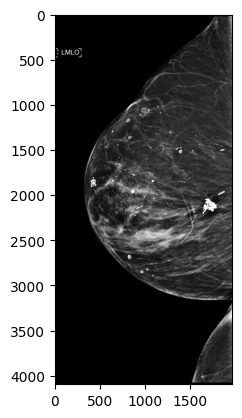

In [1222]:
plt.imshow(load_img)